Thinking of APR. Are we doing the dual optimization with the classification model + the pertubation added?

1. Run BPR and retrieve the model parameters + predict with fixed parameters
2. Use predictions by BPR, train an adversary, save the trained parameters of the MLPs
3. Load parameters of BPR, optimize for a perturbations with the new overall objective

    Loss BPR (with fixed params + perturbation) + Loss adversary (with fixed params + perturbation)


To Do?




4. Tuning for the adversary, check case for 6-groups
5. Test on more extensive dataset
6. Summarize pipeline
7. Check the popularity of REO, RSP. Is this fairness definition widely used?
    - https://github.com/sisinflab/The-Idiosyncratic-Effects-of-Adversarial-Training/tree/main/src/evaluation recsys
    - https://www.semanticscholar.org/reader/f2c12f705aea19ab5e129f72ae9030375f06602f www
    - https://www.semanticscholar.org/reader/1459f5a33ae88d4c26594d867201635651c1dd72 recsys
    - https://oar.a-star.edu.sg/storage/8/8d1z0edy00/lzz-tois-fairness.pdf  TOIS
    - https://www.semanticscholar.org/reader/9eb96c7554d4dac063b47443f38866adbf90b829 recsys
    - https://arxiv.org/pdf/2203.01155.pdf UMAP
8. Will the universal perturbation work for recsys? do we have to fine-tune, add complexity to the perturbation

1. How to compute P(g = G1)? How to retrieve $P_{adv}(i)$ and $P_{adv}(j)$.
- Adversary output probability predicted for each group
- Compute KL divergence between those probability and uniform distribution

2. Audit the formula for REO and RSP -
- Seems alright but cannot reproduce the recall for R@5, R@10, R@15
- Checked all the formulae and coherent with the logics
- The problems might be in the u,i,j generation process?. How do we sample data and negative sample? Each positive sample coupled w 5 negative samples = methodology in the RSP/REO paper
- Code for negative sampling, and evaluation are annotated in utility.py

3. Tranformation function is necessary, how can we define such transformation? i.e. cannot directly optimize embedding + $\delta$ if $\delta$ is just a fixed tensor size = embedding dim
- As of now we keep it as passing the $\delta$ through a Linear(64,64) layer, which doesn't make much sense but helps the code run
- For fairness reprogramming, this transformation can be
    - Identity mapping for MLP
    - Localizing function for CV, which determine the patch of pixels to be perturbed
    - Can we come up with a logical transformation functions? rather than the linear layer?

4. Tuning for the adversary, check case for 6-groups
- Present outcomes for experiments here

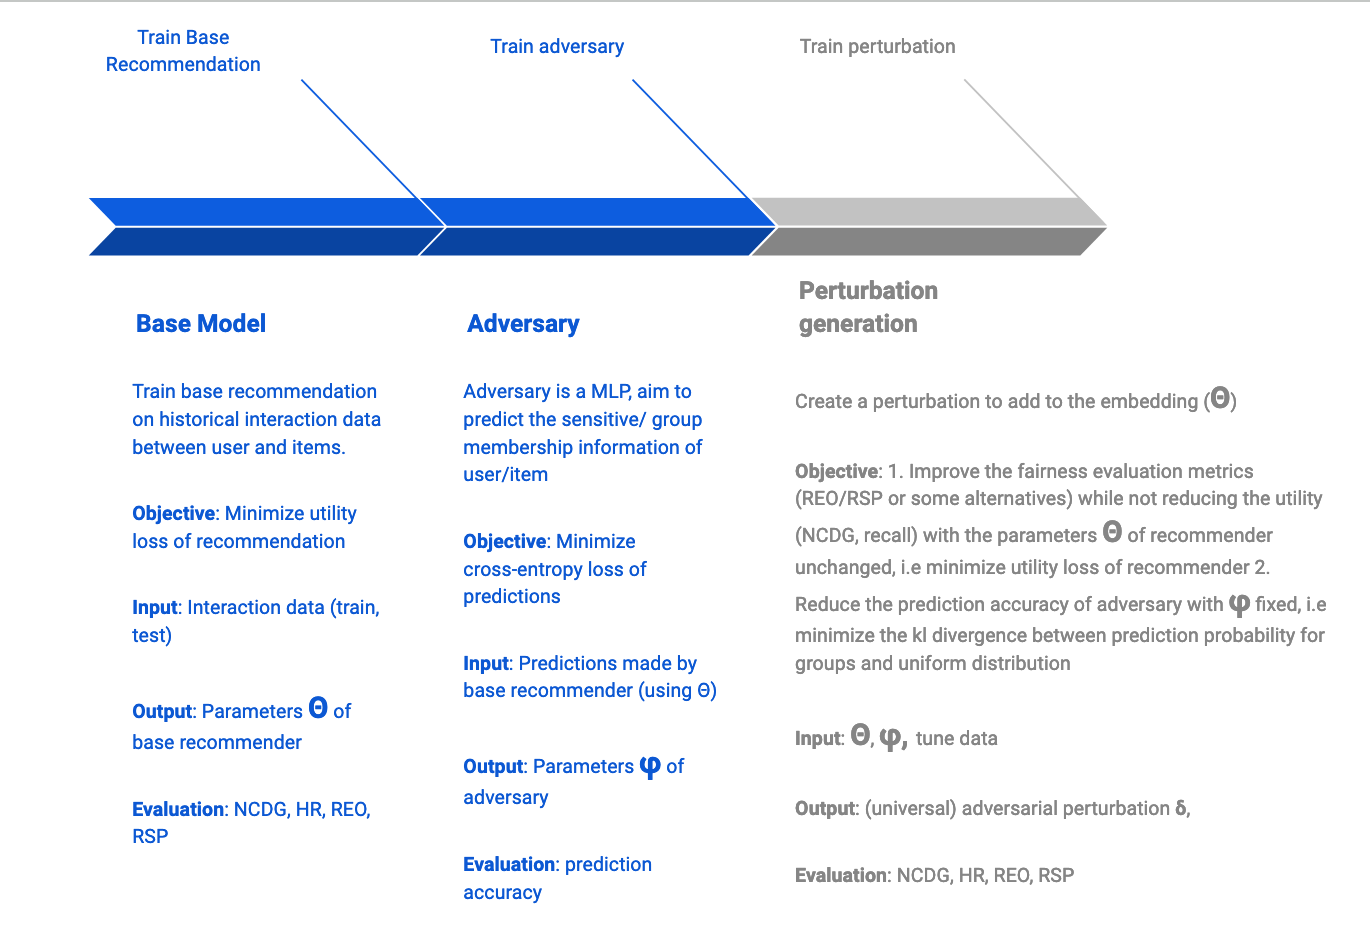

In [1]:
#import relevant library

import math
import os
import random
import pickle
import argparse
from collections import deque
import time
import utility
import tqdm
import copy
from operator import itemgetter
from datetime import timedelta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
# from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [146]:
## time the process
def get_time_dif(start_time):
    """get the running time"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


## set up the u,i,j triplet for BPR framework
class GetTriplePair(IterableDataset):
    # for ml-1m we load in 3760 item 6040 user and 994169 train pair
    def __init__(self, item_size, user_list, pair, shuffle, num_epochs):
        self.item_size = item_size
        self.user_list = user_list
        self.pair = pair
        self.shuffle = shuffle
        self.num_epochs = num_epochs

    def __iter__(self):
        self.example_size = self.num_epochs * len(self.pair) 
        self.example_index_queue = deque([])
        self.seed = 0
        self.start_list_index = None
        self.num_workers = 1
        self.index = 0
        return self

    def __next__(self):
        if self.index >= self.example_size:
            raise StopIteration
        # If `example_index_queue` is used up, replenish this list.
        while len(self.example_index_queue) == 0:
            index_list = list(range(len(self.pair)))
            if self.shuffle:
                random.Random(self.seed).shuffle(index_list)
                self.seed += 1
            if self.start_list_index is not None:
                index_list = index_list[self.start_list_index::self.num_workers]

                # Calculate next start index
                self.start_list_index = (self.start_list_index + (self.num_workers - (len(self.pair) % self.num_workers))) % self.num_workers
            self.example_index_queue.extend(index_list)
        result = self._example(self.example_index_queue.popleft())
        self.index += self.num_workers
        return result

    def _example(self, idx):
        # in a train pair, format = (u,i), j = a random item which does not exist in user u's list of items
#         loop = 0
#         for l in range(5):
        u = self.pair[idx][0]
        i = self.pair[idx][1]
        j = np.random.randint(self.item_size)
        while j in self.user_list[u]:
            j = np.random.randint(self.item_size)
#             loop += 1
        return u, i, j

## chunk to define matrix factorization part
class MF(nn.Module):
    def __init__(self, user_size, item_size, dim, reg, reg_adv, eps):
        super().__init__()
        ##init the embedding for U and I
        self.W = nn.Parameter(torch.empty(user_size, dim))  # User embedding
        self.H = nn.Parameter(torch.empty(item_size, dim))  # Item embedding
        nn.init.xavier_normal_(self.W.data)
        nn.init.xavier_normal_(self.H.data)
        self.reg = reg
        self.user_size = user_size
        self.item_size = item_size
        self.dim = dim
        self.reg_adv = reg_adv
        self.eps = eps
        self.update_u = None
        self.update_i = None
        self.update_j = None

## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.

        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
        u = self.W[u, :]
        i = self.H[i, :]
        j = self.H[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
        u.retain_grad()
        u_clone = u.data.clone()
        i.retain_grad()
        i_clone = i.data.clone()
        j.retain_grad()
        j_clone = j.data.clone()

        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(u, i).sum(dim=1)
        x_uj = torch.mul(u, j).sum(dim=1)


        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
#         log_prob = F.logsigmoid(x_uij).sum()
        log_prob = F.softplus(x_uij).sum() #should we add minus sign here -x_uij

        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (u.norm(dim=1).pow(2).sum() + i.norm(dim=1).pow(2).sum() + j.norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss = -log_prob + regularization

        loss.backward()
        return loss
        # add adv training after a certain number of epochs, here is the part which we add hypernet module
#         if epoch not in range(args.epochs, args.adv_epoch + args.epochs):
#             """Normal training"""
#             loss.backward()
#             return loss

#         else:
#             """Adversarial training:
#                     1.Backward to get grads
#                     2.Construct adversarial perturbation
#                     3.Add adversarial perturbation to embeddings
#                     4.Calculate APR loss
#             """
#             # Backward to get grads
#             # this would be the part we change in defining delta, delta = HPN (phi)

#             # should we calculate based on gradient of the adv_loss instead of the loss function?, originally, computed based on loss function
#             loss.backward(retain_graph=True) ## need to retain graph here so as to we can backprop the adv_loss
#             ##recheck this
#             grad_u = u.grad
#             grad_i = i.grad
#             grad_j = j.grad

#             # Construct adversarial perturbation based on gradient of loss function, and normalize it with epsilon * norm
#             if grad_u is not None:
#                 delta_u = nn.functional.normalize(grad_u, p=2, dim=1, eps=self.eps)
#             else:
#                 delta_u = torch.rand(u.size())
#             if grad_i is not None:
#                 delta_i = nn.functional.normalize(grad_i, p=2, dim=1, eps=self.eps)
#             else:
#                 delta_i = torch.rand(i.size())
#             if grad_j is not None:
#                 delta_j = nn.functional.normalize(grad_j, p=2, dim=1, eps=self.eps)
#             else:
#                 delta_j = torch.rand(j.size())

#             # Add adversarial perturbation to embeddings, now we have q+delta, p+delta
#             x_ui_adv = torch.mul(u + delta_u, i + delta_i).sum(dim=1)
#             x_uj_adv = torch.mul(u + delta_u, j + delta_j).sum(dim=1)

#             # find difference between pos and neg item, then clip value
# #             x_uij_adv = torch.clamp(x_ui_adv - x_uj_adv,min=-80.0,max=1e8)
#             log_prob = torch.sofplus(x_ui_adv - x_uj_adv).sum()
#             # Calculate APR loss with logsigmoid
# #             log_prob = F.logsigmoid(x_uij_adv).sum()
#             adv_loss = self.reg_adv *(-log_prob) + loss # this is adversarial loss (equation 4 in paper)
#             adv_loss.backward()

#             return adv_loss


In [147]:
def evaluate_k(user_emb, item_emb, train_user_list, test_user_list, klist, batch=512):
    """Compute HR and NDCG at k.

    Args:
        user_emb (torch.Tensor): embedding for user [user_num, dim]
        item_emb (torch.Tensor): embedding for item [item_num, dim]
        train_user_list (list(set)):
        test_user_list (list(set)):
        k (list(int)):
    Returns:
        (torch.Tensor, torch.Tensor) HR and NDCG at k
    """

    # Calculate max k value
    max_k = max(klist)
    result = None

    # no iteration = user_num / batch size (which is 512)
    for i in range(0, user_emb.shape[0], batch):

        # Construct mask for each batch

        #new_ones returns a Tensor of size size filled with 1

        # size of the mask vector = (min of batch or user embed) * item+embed
        mask = user_emb.new_ones([min([batch, user_emb.shape[0]-i]), item_emb.shape[0]])
        for j in range(batch):
            if i+j >= user_emb.shape[0]:
                break
            mask[j].scatter_(dim=0, index=torch.tensor(list(train_user_list[i + j])), value=torch.tensor(0.0))

        # Get current result
        cur_result = torch.mm(user_emb[i:i+min(batch, user_emb.shape[0]-i), :], item_emb.t())
        cur_result = torch.sigmoid(cur_result)
        assert not torch.any(torch.isnan(cur_result))

        # Make zero for already observed item
        cur_result = torch.mul(mask, cur_result)
        _, cur_result = torch.topk(cur_result, k=max_k, dim=1)
        result = cur_result if result is None else torch.cat((result, cur_result), dim=0)


    ## basically this chunk collects the results
    result = result.cpu()

    # Sort indice and get HR_NDCG_topk
    HRs, NDCGs = [], []
    for k in klist:
        ndcg, hr = 0, 0
        #for all user
        for i in range(user_emb.shape[0]):
            #set helps to identify unique members in a list
            test = set(test_user_list[i])
            #top k item from prediction list
            pred = set(result[i, :k].numpy().tolist())
            #if topk lies on both test and pred list
            val = len(test & pred)
            #hit ratio = %item hit
            hr += val / max([len(test), 1])
            #convert pred back to list
            pred = list(pred)
            if test_user_list[i] == []:
                continue
            else:
                x = int(test_user_list[i][0])
                ## check if x is in the prediction where x = 1st member of user list
                if pred.count(x) != 0:
                    position = pred.index(x)
                    ndcg += math.log(2) / math.log(position + 2) if position < k else 0
                else:
                    ndcg += 0                
#                 for x in test_user_list[i]:
#                     x = int(x)
#                     ## check if x is in the prediction where x = 1st member of user list
#                     if pred.count(x) != 0:
#                         position = pred.index(x)
#                         ndcg += math.log(2) / math.log(position + 2) if position < k else 0
#                     else:
#                         ndcg += 0
        NDCGs.append(ndcg / user_emb.shape[0])
        HRs.append(hr / user_emb.shape[0])
        NDCGs.append(ndcg / user_emb.shape[0])
    return HRs, NDCGs


In [148]:
# class GetTriplePair_neg_sam(IterableDataset):
#     # for ml-1m we load in 3760 item 6040 user and 994169 train pair
#     def __init__(self, num_sample, user_list, item_pos_list,item_neg_list, shuffle, num_epochs):
#         self.num_sample = num_sample
#         self.user_list = user_list
#         self.item_pos_list = item_pos_list
#         self.item_neg_list = item_neg_list
#         self.shuffle = shuffle
#         self.num_epochs = num_epochs

#     def __iter__(self):
#         self.example_size = self.num_epochs * self.num_sample
#         self.example_index_queue = deque([])
#         self.seed = 0
#         self.start_list_index = None
#         self.num_workers = 1
#         self.index = 0
#         return self

#     def __next__(self):
#         if self.index >= self.example_size:
#             raise StopIteration
#         # If `example_index_queue` is used up, replenish this list.
#         while len(self.example_index_queue) == 0:
#             index_list = list(range(num_sample))
#             if self.shuffle:
#                 random.Random(self.seed).shuffle(index_list)
#                 self.seed += 1
#             if self.start_list_index is not None:
#                 index_list = index_list[self.start_list_index::self.num_workers]

#                 # Calculate next start index
#                 self.start_list_index = (self.start_list_index + (self.num_workers - (len(self.pair) % self.num_workers))) % self.num_workers
#             self.example_index_queue.extend(index_list)
#         result = self._example(self.example_index_queue.popleft())
#         self.index += self.num_workers
#         return result

#     def _example(self, idx):
#         # in a train pair, format = (u,i), j = a random item which does not exist in user u's list of items
#         u = self.user_list[idx]
#         i = self.item_pos_list[idx]
#         j = self.item_neg_list[idx]
# #         while j in self.item_pos_list[u]:
# #             j = np.random.randint(self.item_neg_list)
#         return u, i, j

In [174]:
with open('preprocessed/ml-1m-6-test.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [175]:
# this is for the original implementation
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 1000)

# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
# for the measuring paper, regulalization  = 0.1/2
model = MF(user_size, item_size, 64, 0.05, 1, 0.5)

In [176]:
# # Create dataset, model, optimizer
# dataset = GetTriplePair_neg_sam( num_sample, user_list, item_pos_list,item_neg_list, True, 1000)

# # load batch of 512 item triplets
# loader = DataLoader(dataset, batch_size=512)
# # for the measuring paper, regulalization  = 0.1/2
# model = MF(user_size, item_size, 64, 0.05, 1, 0.5)

In [177]:
optimizer = optim.Adam(model.parameters(), lr=0.00025) #.00025

# Training
start_time = time.time()
eval_best_loss = float('inf')

##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
# result_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(1000):
        loss = model(u, i, j, epoch)

        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(model.W.detach(),
                                        model.H.detach(),
                                        train_user_list,
                                        test_user_list,
                                        klist=[50, 100])
        if epoch % 20 == (20- 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/bpr_manual'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/bpr_manual')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break


time 0:00:01
BPR-MF Epoch [20/1000]
loss: -350.6284
HR@50: 0.0314, HR@100: 0.0605, NDCG@50: 0.0081, NDCG@100: 0.0081
BPR-MF Epoch [40/1000]
loss: -351.3919
HR@50: 0.0285, HR@100: 0.0595, NDCG@50: 0.0074, NDCG@100: 0.0074
BPR-MF Epoch [60/1000]
loss: -352.1586
HR@50: 0.0268, HR@100: 0.0596, NDCG@50: 0.0075, NDCG@100: 0.0075
BPR-MF Epoch [80/1000]
loss: -352.5771
HR@50: 0.0248, HR@100: 0.0562, NDCG@50: 0.0070, NDCG@100: 0.0070
BPR-MF Epoch [100/1000]
loss: -352.9001
HR@50: 0.0260, HR@100: 0.0552, NDCG@50: 0.0076, NDCG@100: 0.0076
time 0:00:17
BPR-MF Epoch [120/1000]
loss: -352.8922
HR@50: 0.0281, HR@100: 0.0582, NDCG@50: 0.0082, NDCG@100: 0.0082
BPR-MF Epoch [140/1000]
loss: -352.7852
HR@50: 0.0322, HR@100: 0.0656, NDCG@50: 0.0089, NDCG@100: 0.0089
BPR-MF Epoch [160/1000]
loss: -352.5462
HR@50: 0.0377, HR@100: 0.0777, NDCG@50: 0.0102, NDCG@100: 0.0102
BPR-MF Epoch [180/1000]
loss: -352.1617
HR@50: 0.0476, HR@100: 0.0920, NDCG@50: 0.0132, NDCG@100: 0.0132
BPR-MF Epoch [200/1000]
loss: -35

for ml-1m-2 data set with continue , epoch 1000 has
loss: 160.6638
HR@50: 0.3218, HR@100: 0.4558, NDCG@50: 0.0939, NDCG@100: 0.0939



for ml-1m-6 data set with continue , epoch 1000 has
loss: 160.6638
HR@50: 0.3218, HR@100: 0.4558, NDCG@50: 0.0939, NDCG@100: 0.0939

for ml-1m-6 data set with continue + for loop for X in test user set , epoch 1000 has
loss: 196.0934
HR@50: 0.3266, HR@100: 0.4649, NDCG@50: 0.7004, NDCG@100: 0.7004


ml-1m normal dataset
loss: 150.8645
HR@50: 0.1437, HR@100: 0.2245, NDCG@50: 0.0365, NDCG@100: 0.0365

test ml-1m normal dataset with for loop for X in test user set
loss: 181.7949
HR@50: 0.1480, HR@100: 0.2252, NDCG@50: 0.0373, NDCG@100: 0.0373

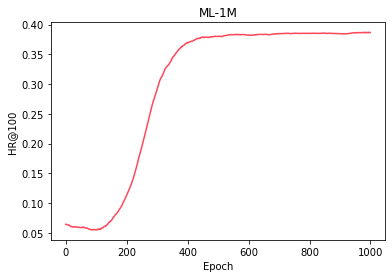

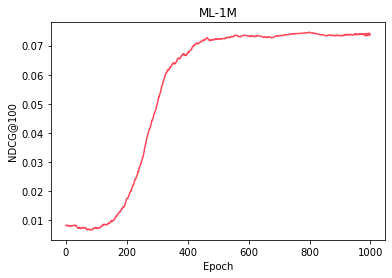

In [178]:
fig_HR = plt.figure(edgecolor='blue')
ax1 = fig_HR.add_subplot(111)
plt.ylabel('HR@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(HR_history)), HR_history, c=np.array([255, 71, 90]) / 255.)
plt.show()
fig_P = plt.figure(edgecolor='blue')
ax1 = fig_P.add_subplot(111)
plt.ylabel('NDCG@100')
plt.xlabel('Epoch')
plt.title('ML-1M')
ax1.plot(range(len(NDCG_history)), NDCG_history, c=np.array([255, 71, 90]) / 255.)
plt.show()

Running a saving output of BPR model

Next up = train adversary based on fixed parameters of BPR

In [179]:
train_df = pd.read_pickle(r'ml1m-6/training_df.pkl')
vali_df = pd.read_pickle(r'ml1m-6/valiing_df.pkl')
key_genre = pd.read_pickle(r'ml1m-6/key_genre.pkl')  
item_idd_genre_list = pd.read_pickle(r'ml1m-6/item_idd_genre_list.pkl')   
genre_item_vector = pd.read_pickle(r'ml1m-6/genre_item_vector.pkl')    
genre_count = pd.read_pickle(r'ml1m-6/genre_count.pkl')      
user_genre_count = pd.read_pickle(r'ml1m-6/user_genre_count.pkl') 

num_item = len(train_df['item_id'].unique())
num_user = len(train_df['user_id'].unique())
num_genre = len(key_genre)

In [140]:
train_df = pd.read_pickle(r'ml1m-2/training_df.pkl')
vali_df = pd.read_pickle(r'ml1m-2/valiing_df.pkl')
key_genre = pd.read_pickle(r'ml1m-2/key_genre.pkl')  
item_idd_genre_list = pd.read_pickle(r'ml1m-2/item_idd_genre_list.pkl')   
genre_item_vector = pd.read_pickle(r'ml1m-2/genre_item_vector.pkl')    
genre_count = pd.read_pickle(r'ml1m-2/genre_count.pkl')      
user_genre_count = pd.read_pickle(r'ml1m-2/user_genre_count.pkl') 

num_item = len(train_df['item_id'].unique())
num_user = len(train_df['user_id'].unique())
num_genre = len(key_genre)

In [180]:
genre_count

{'Sci-Fi': 271,
 'Horror': 330,
 'Crime': 193,
 'Romance': 447,
 "Children's": 248,
 'Adventure': 276}

In [181]:
item_genre_list = []
for u in range(num_item):
    gl = item_idd_genre_list[u]
    tmp = []
    for g in gl:
        if g in key_genre:
            tmp.append(g)
    item_genre_list.append(tmp)

item_genre = np.zeros((num_item, num_genre))
for i in range(num_item):
    gl = item_genre_list[i]
    for k in range(num_genre):
        if key_genre[k] in gl:
            item_genre[i, k] = 1.0

genre_count_mean_reciprocal = []

##there are six key_genre --> in the training dataset, count the number of movies for each genre
#genre_count = dictionary with number of movies for each keygrenre
for k in key_genre:
    genre_count_mean_reciprocal.append(1.0 / genre_count[k])
genre_count_mean_reciprocal = (np.array(genre_count_mean_reciprocal)).reshape((num_genre, 1))
genre_error_weight = np.dot(item_genre, genre_count_mean_reciprocal)

In [182]:
genre_count_mean_reciprocal

array([[0.00369004],
       [0.0030303 ],
       [0.00518135],
       [0.00362319],
       [0.00403226],
       [0.00223714]])

In [183]:
item_genre = torch.from_numpy(item_genre).type(torch.float)
item_genre.size()

torch.Size([1481, 6])

In [184]:
#load the results of BPR
model1 = (torch.load('output/bpr_manual'))
list(model1.items())[0][1].size(),list(model1.items())[1][1].size()




(torch.Size([6036, 64]), torch.Size([1481, 64]))

In [185]:
list(model1.items())[1][1]

tensor([[-0.2531,  0.3342,  0.2647,  ...,  0.2452, -0.3709,  0.3363],
        [-0.3336,  0.3607,  0.4106,  ...,  0.3912, -0.3559,  0.4037],
        [-0.3836,  0.4013,  0.3976,  ...,  0.4661, -0.4326,  0.4119],
        ...,
        [ 0.3760, -0.4413, -0.4247,  ..., -0.3749,  0.3412, -0.4609],
        [ 0.4010, -0.4269, -0.3794,  ..., -0.4609,  0.3905, -0.4556],
        [ 0.3525, -0.4291, -0.4467,  ..., -0.4498,  0.3614, -0.4141]])

In [186]:
Rec = np.matmul(list(model1.items())[0][1], list(model1.items())[1][1].T)
Rec.size()
# Rec[1,:].size()


torch.Size([6036, 1481])

In [187]:
import utility
utility.ranking_analysis(Rec, vali_df, train_df, key_genre,
                                                      item_genre_list, user_genre_count)

/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:310: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:310: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx


####################################################################################################
# System-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00542		0.02927		0.06212		0.09605
# Horror		0.00027		0.00040		0.00040		0.00040
# Crime		0.00013		0.00064		0.00102		0.00165
# Adventure		0.00053		0.00295		0.00658		0.01014
# Children's		0.00527		0.02510		0.04826		0.07156
# Romance		0.00000		0.00000		0.00027		0.00082
# relative std		1.24849		1.27897		1.28692		1.28766
####################################################################################################
# User-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00383		0.02024		0.04346		0.06729
# Horror		0.00007		0.00026		0.00026		0.00026
# Crime		0.00010		0.00057		0.00080		0.00123
# Adventure		0.00139		0.00733		0.01497		0.02267
# Children's		0.00875		0.04193		0.08036		0.11930
# Romance		0.00000		0.00000		0.00013		0.00063
# relative std		1.33995		1.30187		1.27459		1.26029
###########

(array([0.91662489, 0.92583772, 0.9159267 , 0.90423987]),
 array([1.24849113, 1.27897029, 1.28691682, 1.28765904]))

In [188]:
utility.test_model_all(Rec, vali_df, train_df)

/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T #u_pred[top15_item_idx_no_train]= np.partition(u_pred, -1 * top4)[-1 * top4:]
/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

precision_1	[0.0473299],	||	 precision_5	[0.0560100],	||	 precision_10	[0.0618861],	||	 precision_15	[0.0646544]
recall_1   	[0.0057274],	||	 recall_5   	[0.0331991],	||	 recall_10   	[0.0729547],	||	 recall_15   	[0.1155516]
f_measure_1	[0.0102183],	||	 f_measure_5	[0.0416882],	||	 f_measure_10	[0.0669661],	||	 f_measure_15	[0.0829153]
ndcg_1     	[0.0473299],	||	 ndcg_5     	[0.0579117],	||	 ndcg_10     	[0.0727018],	||	 ndcg_15     	[0.0880395]


(array([0.04732988, 0.05601   , 0.06188605, 0.0646544 ]),
 array([0.00572738, 0.03319912, 0.07295468, 0.11555155]),
 [0.010218253655308119,
  0.04168817632128664,
  0.06696607080034957,
  0.08291531314634645],
 array([0.04732988, 0.05791166, 0.07270179, 0.0880395 ]))

In [189]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Rec.T, 
                                                    item_genre, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=181) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(1184, 297, 1184, 297)

In [190]:
#adv, linear-relu, linear-sigmoid last layer, numlayer = 4, 512,256,128,64 hidden units 

adversary = nn.Sequential(
    nn.Linear(list(model1.items())[0][1].size()[0], 512),
#     nn.ReLU(),
    nn.Linear(512, 256),
#     nn.ReLU(),
    nn.Linear(256, 128),
#     nn.ReLU(),
    nn.Linear(128, 6),
#     nn.Softmax(dim=1)
)

In [191]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.CrossEntropyLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.Adam(params=adversary.parameters(), 
                            lr=0.000005)

In [192]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [193]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / (y_true.size()[0]*y_true.size()[1])) * 100 
    return acc

In [194]:
torch.manual_seed(18)

# Set the number of epochs
epochs = 500

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    adversary.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = adversary(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = F.softmax(y_logits, dim=1) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    adversary.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = adversary(X_test).squeeze() 
        test_pred =  F.softmax(test_logits, dim=1)
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2854.06763, Accuracy: 68.27% | Test loss: 2531.81274, Test acc: 68.29%
Epoch: 10 | Loss: 1612.84302, Accuracy: 74.49% | Test loss: 1800.91187, Test acc: 74.92%
Epoch: 20 | Loss: 980.34576, Accuracy: 80.11% | Test loss: 1413.68774, Test acc: 78.68%
Epoch: 30 | Loss: 647.11023, Accuracy: 84.47% | Test loss: 1219.14758, Test acc: 80.58%
Epoch: 40 | Loss: 446.31149, Accuracy: 86.75% | Test loss: 1102.17334, Test acc: 82.83%
Epoch: 50 | Loss: 311.78915, Accuracy: 88.32% | Test loss: 1021.51581, Test acc: 83.56%
Epoch: 60 | Loss: 221.44093, Accuracy: 89.22% | Test loss: 984.29419, Test acc: 84.01%
Epoch: 70 | Loss: 162.72888, Accuracy: 90.05% | Test loss: 965.61322, Test acc: 84.18%
Epoch: 80 | Loss: 126.58308, Accuracy: 90.62% | Test loss: 955.45276, Test acc: 84.29%
Epoch: 90 | Loss: 103.74332, Accuracy: 90.92% | Test loss: 946.67426, Test acc: 84.68%
Epoch: 100 | Loss: 82.93568, Accuracy: 90.79% | Test loss: 939.49518, Test acc: 84.74%
Epoch: 110 | Loss: 72.32265, Accurac

In [49]:
# # prepare model and training parameters
# n_epochs = 500
# batch_size = 50
# batches_per_epoch = len(X_train) // batch_size
 
# best_acc = - np.inf   # init to negative infinity
# best_weights = None
# train_loss_hist = []
# train_acc_hist = []
# test_loss_hist = []
# test_acc_hist = []
 
# # training loop
# for epoch in range(n_epochs):
#     epoch_loss = []
#     epoch_acc = []
#     # set model in training mode and run through each batch
#     adversary.train()
#     with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
#         bar.set_description(f"Epoch {epoch}")
#         for i in bar:
#             # take a batch
#             start = i * batch_size
#             X_batch = X_train[start:start+batch_size]
#             y_batch = y_train[start:start+batch_size]
#             # forward pass
#             y_pred = adversary(X_batch)
#             loss = loss_fn(y_pred, y_batch)
#             # backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             # update weights
#             optimizer.step()
#             # compute and store metrics
#             acc = accuracy_fn(y_true=y_batch, 
#                       y_pred=y_pred)
#             epoch_loss.append(float(loss))
#             epoch_acc.append(float(acc))
#             bar.set_postfix(
#                 loss=float(loss),
#                 acc=float(acc)
#             )
#     # set model in evaluation mode and run through the test set
#     adversary.eval()
#     y_pred = adversary(X_test)
#     ce = loss_fn(y_pred, y_test)
#     acc = accuracy_fn(y_true=y_test, 
#                       y_pred=y_pred)
#     ce = float(ce)
#     acc = float(acc)
#     train_loss_hist.append(np.mean(epoch_loss))
#     train_acc_hist.append(np.mean(epoch_acc))
#     test_loss_hist.append(ce)
#     test_acc_hist.append(acc)
#     if acc > best_acc:
#         best_acc = acc
#         best_weights = copy.deepcopy(adversary.state_dict())
#     print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc:.1f}%")
 


Epoch 0: 100%|███████████| 23/23 [00:00<00:00, 62.13batch/s, acc=82, loss=0.696]


Epoch 0 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 1: 100%|█████████| 23/23 [00:00<00:00, 49.60batch/s, acc=81.3, loss=0.696]


Epoch 1 validation: Cross-entropy=0.70, Accuracy=81.4%


Epoch 2: 100%|█████████| 23/23 [00:00<00:00, 61.09batch/s, acc=81.3, loss=0.696]


Epoch 2 validation: Cross-entropy=0.70, Accuracy=81.7%


Epoch 3: 100%|█████████| 23/23 [00:00<00:00, 52.58batch/s, acc=81.3, loss=0.696]


Epoch 3 validation: Cross-entropy=0.70, Accuracy=81.6%


Epoch 4: 100%|█████████| 23/23 [00:00<00:00, 53.33batch/s, acc=81.7, loss=0.696]


Epoch 4 validation: Cross-entropy=0.70, Accuracy=81.6%


Epoch 5: 100%|█████████| 23/23 [00:00<00:00, 50.81batch/s, acc=81.7, loss=0.696]


Epoch 5 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 6: 100%|█████████| 23/23 [00:00<00:00, 58.93batch/s, acc=81.3, loss=0.696]


Epoch 6 validation: Cross-entropy=0.71, Accuracy=80.8%


Epoch 7: 100%|█████████| 23/23 [00:00<00:00, 51.77batch/s, acc=81.3, loss=0.696]


Epoch 7 validation: Cross-entropy=0.71, Accuracy=80.5%


Epoch 8: 100%|█████████| 23/23 [00:00<00:00, 50.42batch/s, acc=80.7, loss=0.703]


Epoch 8 validation: Cross-entropy=0.71, Accuracy=80.6%


Epoch 9: 100%|███████████| 23/23 [00:00<00:00, 60.32batch/s, acc=80, loss=0.706]


Epoch 9 validation: Cross-entropy=0.70, Accuracy=80.8%


Epoch 10: 100%|██████████| 23/23 [00:00<00:00, 54.04batch/s, acc=80, loss=0.706]


Epoch 10 validation: Cross-entropy=0.70, Accuracy=80.6%


Epoch 11: 100%|████████| 23/23 [00:00<00:00, 52.34batch/s, acc=80.3, loss=0.703]


Epoch 11 validation: Cross-entropy=0.70, Accuracy=80.5%


Epoch 12: 100%|██████████| 23/23 [00:00<00:00, 52.25batch/s, acc=81, loss=0.701]


Epoch 12 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 13: 100%|████████| 23/23 [00:00<00:00, 72.24batch/s, acc=80.3, loss=0.703]


Epoch 13 validation: Cross-entropy=0.70, Accuracy=80.9%


Epoch 14: 100%|████████| 23/23 [00:00<00:00, 63.58batch/s, acc=80.7, loss=0.706]


Epoch 14 validation: Cross-entropy=0.70, Accuracy=81.2%


Epoch 15: 100%|████████| 23/23 [00:00<00:00, 63.99batch/s, acc=80.7, loss=0.706]


Epoch 15 validation: Cross-entropy=0.70, Accuracy=81.2%


Epoch 16: 100%|████████| 23/23 [00:00<00:00, 56.47batch/s, acc=80.7, loss=0.706]


Epoch 16 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 17: 100%|████████| 23/23 [00:00<00:00, 62.27batch/s, acc=80.7, loss=0.706]


Epoch 17 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 18: 100%|████████| 23/23 [00:00<00:00, 58.65batch/s, acc=80.7, loss=0.706]


Epoch 18 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 19: 100%|████████| 23/23 [00:00<00:00, 58.60batch/s, acc=80.7, loss=0.706]


Epoch 19 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 20: 100%|████████| 23/23 [00:00<00:00, 59.57batch/s, acc=80.7, loss=0.706]


Epoch 20 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 21: 100%|████████| 23/23 [00:00<00:00, 59.20batch/s, acc=80.7, loss=0.706]


Epoch 21 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 22: 100%|████████| 23/23 [00:00<00:00, 58.71batch/s, acc=80.7, loss=0.706]


Epoch 22 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 23: 100%|████████| 23/23 [00:00<00:00, 64.63batch/s, acc=80.7, loss=0.706]


Epoch 23 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 24: 100%|████████| 23/23 [00:00<00:00, 60.68batch/s, acc=80.7, loss=0.706]


Epoch 24 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 25: 100%|████████| 23/23 [00:00<00:00, 59.01batch/s, acc=80.7, loss=0.706]


Epoch 25 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 26: 100%|████████| 23/23 [00:00<00:00, 57.85batch/s, acc=80.7, loss=0.706]


Epoch 26 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 27: 100%|████████| 23/23 [00:00<00:00, 59.26batch/s, acc=80.7, loss=0.706]


Epoch 27 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 28: 100%|████████| 23/23 [00:00<00:00, 55.94batch/s, acc=80.7, loss=0.706]


Epoch 28 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 29: 100%|████████| 23/23 [00:00<00:00, 57.33batch/s, acc=80.7, loss=0.706]


Epoch 29 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 30: 100%|████████| 23/23 [00:00<00:00, 60.58batch/s, acc=80.7, loss=0.706]


Epoch 30 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 31: 100%|████████| 23/23 [00:00<00:00, 53.91batch/s, acc=80.7, loss=0.706]


Epoch 31 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 32: 100%|████████| 23/23 [00:00<00:00, 61.44batch/s, acc=80.7, loss=0.706]


Epoch 32 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 33: 100%|████████| 23/23 [00:00<00:00, 64.21batch/s, acc=80.7, loss=0.706]


Epoch 33 validation: Cross-entropy=0.70, Accuracy=81.3%


Epoch 34: 100%|████████| 23/23 [00:00<00:00, 58.32batch/s, acc=80.7, loss=0.706]


Epoch 34 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 35: 100%|████████| 23/23 [00:00<00:00, 69.57batch/s, acc=80.7, loss=0.706]


Epoch 35 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 36: 100%|████████| 23/23 [00:00<00:00, 66.25batch/s, acc=80.7, loss=0.706]


Epoch 36 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 37: 100%|████████| 23/23 [00:00<00:00, 72.30batch/s, acc=80.7, loss=0.706]


Epoch 37 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 38: 100%|████████| 23/23 [00:00<00:00, 61.36batch/s, acc=80.7, loss=0.706]


Epoch 38 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 39: 100%|████████| 23/23 [00:00<00:00, 65.76batch/s, acc=80.7, loss=0.706]


Epoch 39 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 40: 100%|████████| 23/23 [00:00<00:00, 61.73batch/s, acc=80.7, loss=0.706]


Epoch 40 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 41: 100%|████████| 23/23 [00:00<00:00, 64.54batch/s, acc=80.7, loss=0.706]


Epoch 41 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 42: 100%|████████| 23/23 [00:00<00:00, 64.38batch/s, acc=80.7, loss=0.706]


Epoch 42 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 43: 100%|████████| 23/23 [00:00<00:00, 64.53batch/s, acc=80.7, loss=0.706]


Epoch 43 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 44: 100%|████████| 23/23 [00:00<00:00, 62.69batch/s, acc=80.7, loss=0.706]


Epoch 44 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 45: 100%|████████| 23/23 [00:00<00:00, 69.17batch/s, acc=80.7, loss=0.706]


Epoch 45 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 46: 100%|████████| 23/23 [00:00<00:00, 63.06batch/s, acc=80.7, loss=0.706]


Epoch 46 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 47: 100%|████████| 23/23 [00:00<00:00, 66.77batch/s, acc=80.7, loss=0.706]


Epoch 47 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 48: 100%|████████| 23/23 [00:00<00:00, 62.64batch/s, acc=80.7, loss=0.706]


Epoch 48 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 49: 100%|████████| 23/23 [00:00<00:00, 59.89batch/s, acc=80.7, loss=0.706]


Epoch 49 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 50: 100%|████████| 23/23 [00:00<00:00, 54.33batch/s, acc=80.7, loss=0.706]


Epoch 50 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 51: 100%|████████| 23/23 [00:00<00:00, 58.79batch/s, acc=80.7, loss=0.706]


Epoch 51 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 52: 100%|████████| 23/23 [00:00<00:00, 59.49batch/s, acc=80.7, loss=0.706]


Epoch 52 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 53: 100%|████████| 23/23 [00:00<00:00, 57.11batch/s, acc=80.7, loss=0.706]


Epoch 53 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 54: 100%|████████| 23/23 [00:00<00:00, 68.13batch/s, acc=80.7, loss=0.706]


Epoch 54 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 55: 100%|████████| 23/23 [00:00<00:00, 48.72batch/s, acc=80.7, loss=0.706]


Epoch 55 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 56: 100%|████████| 23/23 [00:00<00:00, 61.53batch/s, acc=80.7, loss=0.706]


Epoch 56 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 57: 100%|████████| 23/23 [00:00<00:00, 62.94batch/s, acc=80.7, loss=0.706]


Epoch 57 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 58: 100%|████████| 23/23 [00:00<00:00, 57.79batch/s, acc=80.7, loss=0.706]


Epoch 58 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 59: 100%|████████| 23/23 [00:00<00:00, 62.03batch/s, acc=80.7, loss=0.706]


Epoch 59 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 60: 100%|████████| 23/23 [00:00<00:00, 58.46batch/s, acc=80.7, loss=0.706]


Epoch 60 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 61: 100%|████████| 23/23 [00:00<00:00, 62.93batch/s, acc=80.7, loss=0.706]


Epoch 61 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 62: 100%|████████| 23/23 [00:00<00:00, 57.94batch/s, acc=80.7, loss=0.706]


Epoch 62 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 63: 100%|████████| 23/23 [00:00<00:00, 61.18batch/s, acc=80.7, loss=0.706]


Epoch 63 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 64: 100%|████████| 23/23 [00:00<00:00, 60.64batch/s, acc=80.7, loss=0.706]


Epoch 64 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 65: 100%|████████| 23/23 [00:00<00:00, 53.92batch/s, acc=80.7, loss=0.706]


Epoch 65 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 66: 100%|████████| 23/23 [00:00<00:00, 62.47batch/s, acc=80.7, loss=0.706]


Epoch 66 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 67: 100%|████████| 23/23 [00:00<00:00, 63.99batch/s, acc=80.7, loss=0.706]


Epoch 67 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 68: 100%|████████| 23/23 [00:00<00:00, 61.12batch/s, acc=80.7, loss=0.706]


Epoch 68 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 69: 100%|████████| 23/23 [00:00<00:00, 66.46batch/s, acc=80.7, loss=0.706]


Epoch 69 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 70: 100%|████████| 23/23 [00:00<00:00, 61.58batch/s, acc=80.7, loss=0.706]


Epoch 70 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 71: 100%|████████| 23/23 [00:00<00:00, 67.67batch/s, acc=80.7, loss=0.706]


Epoch 71 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 72: 100%|████████| 23/23 [00:00<00:00, 63.63batch/s, acc=80.7, loss=0.706]


Epoch 72 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 73: 100%|████████| 23/23 [00:00<00:00, 67.69batch/s, acc=80.7, loss=0.706]


Epoch 73 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 74: 100%|████████| 23/23 [00:00<00:00, 59.45batch/s, acc=80.7, loss=0.706]


Epoch 74 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 75: 100%|████████| 23/23 [00:00<00:00, 62.12batch/s, acc=80.7, loss=0.706]


Epoch 75 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 76: 100%|████████| 23/23 [00:00<00:00, 71.70batch/s, acc=80.7, loss=0.706]


Epoch 76 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 77: 100%|████████| 23/23 [00:00<00:00, 67.65batch/s, acc=80.7, loss=0.706]


Epoch 77 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 78: 100%|████████| 23/23 [00:00<00:00, 61.02batch/s, acc=80.7, loss=0.706]


Epoch 78 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 79: 100%|████████| 23/23 [00:00<00:00, 66.24batch/s, acc=80.7, loss=0.706]


Epoch 79 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 80: 100%|████████| 23/23 [00:00<00:00, 65.72batch/s, acc=80.7, loss=0.706]


Epoch 80 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 81: 100%|████████| 23/23 [00:00<00:00, 65.20batch/s, acc=80.7, loss=0.706]


Epoch 81 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 82: 100%|████████| 23/23 [00:00<00:00, 76.43batch/s, acc=80.7, loss=0.706]


Epoch 82 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 83: 100%|████████| 23/23 [00:00<00:00, 69.21batch/s, acc=80.7, loss=0.706]


Epoch 83 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 84: 100%|████████| 23/23 [00:00<00:00, 63.68batch/s, acc=80.7, loss=0.706]


Epoch 84 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 85: 100%|████████| 23/23 [00:00<00:00, 63.93batch/s, acc=80.7, loss=0.706]


Epoch 85 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 86: 100%|████████| 23/23 [00:00<00:00, 61.19batch/s, acc=80.7, loss=0.706]


Epoch 86 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 87: 100%|████████| 23/23 [00:00<00:00, 57.88batch/s, acc=80.7, loss=0.706]


Epoch 87 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 88: 100%|████████| 23/23 [00:00<00:00, 63.39batch/s, acc=80.7, loss=0.706]


Epoch 88 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 89: 100%|████████| 23/23 [00:00<00:00, 66.15batch/s, acc=80.7, loss=0.706]


Epoch 89 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 90: 100%|████████| 23/23 [00:00<00:00, 62.93batch/s, acc=80.7, loss=0.706]


Epoch 90 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 91: 100%|████████| 23/23 [00:00<00:00, 61.77batch/s, acc=80.7, loss=0.706]


Epoch 91 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 92: 100%|████████| 23/23 [00:00<00:00, 60.70batch/s, acc=80.7, loss=0.706]


Epoch 92 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 93: 100%|████████| 23/23 [00:00<00:00, 61.41batch/s, acc=80.7, loss=0.706]


Epoch 93 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 94: 100%|████████| 23/23 [00:00<00:00, 64.42batch/s, acc=80.7, loss=0.706]


Epoch 94 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 95: 100%|████████| 23/23 [00:00<00:00, 60.92batch/s, acc=80.7, loss=0.706]


Epoch 95 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 96: 100%|████████| 23/23 [00:00<00:00, 63.03batch/s, acc=80.7, loss=0.706]


Epoch 96 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 97: 100%|████████| 23/23 [00:00<00:00, 62.99batch/s, acc=80.7, loss=0.706]


Epoch 97 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 98: 100%|████████| 23/23 [00:00<00:00, 60.45batch/s, acc=80.7, loss=0.706]


Epoch 98 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 99: 100%|████████| 23/23 [00:00<00:00, 62.74batch/s, acc=80.7, loss=0.706]


Epoch 99 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 100: 100%|███████| 23/23 [00:00<00:00, 56.75batch/s, acc=80.7, loss=0.706]


Epoch 100 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 101: 100%|███████| 23/23 [00:00<00:00, 65.44batch/s, acc=80.7, loss=0.706]


Epoch 101 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 102: 100%|███████| 23/23 [00:00<00:00, 65.39batch/s, acc=80.7, loss=0.706]


Epoch 102 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 103: 100%|███████| 23/23 [00:00<00:00, 61.81batch/s, acc=80.7, loss=0.706]


Epoch 103 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 104: 100%|███████| 23/23 [00:00<00:00, 61.36batch/s, acc=80.7, loss=0.706]


Epoch 104 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 105: 100%|███████| 23/23 [00:00<00:00, 65.28batch/s, acc=80.7, loss=0.706]


Epoch 105 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 106: 100%|███████| 23/23 [00:00<00:00, 61.46batch/s, acc=80.7, loss=0.706]


Epoch 106 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 107: 100%|███████| 23/23 [00:00<00:00, 64.99batch/s, acc=80.7, loss=0.706]


Epoch 107 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 108: 100%|███████| 23/23 [00:00<00:00, 61.51batch/s, acc=80.7, loss=0.706]


Epoch 108 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 109: 100%|███████| 23/23 [00:00<00:00, 60.98batch/s, acc=80.7, loss=0.706]


Epoch 109 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 110: 100%|███████| 23/23 [00:00<00:00, 63.77batch/s, acc=80.7, loss=0.706]


Epoch 110 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 111: 100%|███████| 23/23 [00:00<00:00, 65.41batch/s, acc=80.7, loss=0.706]


Epoch 111 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 112: 100%|███████| 23/23 [00:00<00:00, 65.05batch/s, acc=80.7, loss=0.706]


Epoch 112 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 113: 100%|███████| 23/23 [00:00<00:00, 68.02batch/s, acc=80.7, loss=0.706]


Epoch 113 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 114: 100%|███████| 23/23 [00:00<00:00, 67.92batch/s, acc=80.7, loss=0.706]


Epoch 114 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 115: 100%|███████| 23/23 [00:00<00:00, 60.50batch/s, acc=80.7, loss=0.706]


Epoch 115 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 116: 100%|███████| 23/23 [00:00<00:00, 62.25batch/s, acc=80.7, loss=0.706]


Epoch 116 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 117: 100%|███████| 23/23 [00:00<00:00, 61.72batch/s, acc=80.7, loss=0.706]


Epoch 117 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 118: 100%|███████| 23/23 [00:00<00:00, 58.27batch/s, acc=80.7, loss=0.706]


Epoch 118 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 119: 100%|███████| 23/23 [00:00<00:00, 62.83batch/s, acc=80.7, loss=0.706]


Epoch 119 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 120: 100%|███████| 23/23 [00:00<00:00, 61.48batch/s, acc=80.7, loss=0.706]


Epoch 120 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 121: 100%|███████| 23/23 [00:00<00:00, 62.26batch/s, acc=80.7, loss=0.706]


Epoch 121 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 122: 100%|███████| 23/23 [00:00<00:00, 63.98batch/s, acc=80.7, loss=0.706]


Epoch 122 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 123: 100%|███████| 23/23 [00:00<00:00, 61.40batch/s, acc=80.7, loss=0.706]


Epoch 123 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 124: 100%|███████| 23/23 [00:00<00:00, 59.28batch/s, acc=80.7, loss=0.706]


Epoch 124 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 125: 100%|███████| 23/23 [00:00<00:00, 63.80batch/s, acc=80.7, loss=0.706]


Epoch 125 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 126: 100%|███████| 23/23 [00:00<00:00, 59.18batch/s, acc=80.7, loss=0.706]


Epoch 126 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 127: 100%|███████| 23/23 [00:00<00:00, 61.08batch/s, acc=80.7, loss=0.706]


Epoch 127 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 128: 100%|███████| 23/23 [00:00<00:00, 61.40batch/s, acc=80.7, loss=0.706]


Epoch 128 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 129: 100%|███████| 23/23 [00:00<00:00, 60.16batch/s, acc=80.7, loss=0.706]


Epoch 129 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 130: 100%|███████| 23/23 [00:00<00:00, 59.04batch/s, acc=80.7, loss=0.706]


Epoch 130 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 131: 100%|███████| 23/23 [00:00<00:00, 63.49batch/s, acc=80.7, loss=0.706]


Epoch 131 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 132: 100%|███████| 23/23 [00:00<00:00, 59.24batch/s, acc=80.7, loss=0.706]


Epoch 132 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 133: 100%|███████| 23/23 [00:00<00:00, 62.46batch/s, acc=80.7, loss=0.706]


Epoch 133 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 134: 100%|███████| 23/23 [00:00<00:00, 65.90batch/s, acc=80.7, loss=0.706]


Epoch 134 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 135: 100%|███████| 23/23 [00:00<00:00, 58.21batch/s, acc=80.7, loss=0.706]


Epoch 135 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 136: 100%|███████| 23/23 [00:00<00:00, 59.61batch/s, acc=80.7, loss=0.706]


Epoch 136 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 137: 100%|███████| 23/23 [00:00<00:00, 63.31batch/s, acc=80.7, loss=0.706]


Epoch 137 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 138: 100%|███████| 23/23 [00:00<00:00, 63.60batch/s, acc=80.7, loss=0.706]


Epoch 138 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 139: 100%|███████| 23/23 [00:00<00:00, 57.30batch/s, acc=80.7, loss=0.706]


Epoch 139 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 140: 100%|███████| 23/23 [00:00<00:00, 67.55batch/s, acc=80.7, loss=0.706]


Epoch 140 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 141: 100%|███████| 23/23 [00:00<00:00, 62.13batch/s, acc=80.7, loss=0.706]


Epoch 141 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 142: 100%|███████| 23/23 [00:00<00:00, 63.34batch/s, acc=80.7, loss=0.706]


Epoch 142 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 143: 100%|███████| 23/23 [00:00<00:00, 58.66batch/s, acc=80.7, loss=0.706]


Epoch 143 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 144: 100%|███████| 23/23 [00:00<00:00, 68.88batch/s, acc=80.7, loss=0.706]


Epoch 144 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 145: 100%|███████| 23/23 [00:00<00:00, 58.29batch/s, acc=80.7, loss=0.706]


Epoch 145 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 146: 100%|███████| 23/23 [00:00<00:00, 55.66batch/s, acc=80.7, loss=0.706]


Epoch 146 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 147: 100%|███████| 23/23 [00:00<00:00, 67.38batch/s, acc=80.7, loss=0.706]


Epoch 147 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 148: 100%|███████| 23/23 [00:00<00:00, 58.81batch/s, acc=80.7, loss=0.706]


Epoch 148 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 149: 100%|███████| 23/23 [00:00<00:00, 61.14batch/s, acc=80.7, loss=0.706]


Epoch 149 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 150: 100%|███████| 23/23 [00:00<00:00, 57.38batch/s, acc=80.7, loss=0.706]


Epoch 150 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 151: 100%|███████| 23/23 [00:00<00:00, 66.34batch/s, acc=80.7, loss=0.706]


Epoch 151 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 152: 100%|███████| 23/23 [00:00<00:00, 63.10batch/s, acc=80.7, loss=0.706]


Epoch 152 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 153: 100%|███████| 23/23 [00:00<00:00, 61.47batch/s, acc=80.7, loss=0.706]


Epoch 153 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 154: 100%|███████| 23/23 [00:00<00:00, 63.27batch/s, acc=80.7, loss=0.706]


Epoch 154 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 155: 100%|███████| 23/23 [00:00<00:00, 60.53batch/s, acc=80.7, loss=0.706]


Epoch 155 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 156: 100%|███████| 23/23 [00:00<00:00, 54.88batch/s, acc=80.7, loss=0.706]


Epoch 156 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 157: 100%|███████| 23/23 [00:00<00:00, 63.08batch/s, acc=80.7, loss=0.706]


Epoch 157 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 158: 100%|███████| 23/23 [00:00<00:00, 59.75batch/s, acc=80.7, loss=0.706]


Epoch 158 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 159: 100%|███████| 23/23 [00:00<00:00, 59.94batch/s, acc=80.7, loss=0.706]


Epoch 159 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 160: 100%|███████| 23/23 [00:00<00:00, 63.55batch/s, acc=80.7, loss=0.706]


Epoch 160 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 161: 100%|███████| 23/23 [00:00<00:00, 62.16batch/s, acc=80.7, loss=0.706]


Epoch 161 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 162: 100%|███████| 23/23 [00:00<00:00, 64.31batch/s, acc=80.7, loss=0.706]


Epoch 162 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 163: 100%|███████| 23/23 [00:00<00:00, 59.55batch/s, acc=80.7, loss=0.706]


Epoch 163 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 164: 100%|███████| 23/23 [00:00<00:00, 59.45batch/s, acc=80.7, loss=0.706]


Epoch 164 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 165: 100%|███████| 23/23 [00:00<00:00, 60.69batch/s, acc=80.7, loss=0.706]


Epoch 165 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 166: 100%|███████| 23/23 [00:00<00:00, 64.02batch/s, acc=80.7, loss=0.706]


Epoch 166 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 167: 100%|███████| 23/23 [00:00<00:00, 64.68batch/s, acc=80.7, loss=0.706]


Epoch 167 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 168: 100%|███████| 23/23 [00:00<00:00, 58.45batch/s, acc=80.7, loss=0.706]


Epoch 168 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 169: 100%|███████| 23/23 [00:00<00:00, 68.64batch/s, acc=80.7, loss=0.706]


Epoch 169 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 170: 100%|███████| 23/23 [00:00<00:00, 65.02batch/s, acc=80.7, loss=0.706]


Epoch 170 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 171: 100%|███████| 23/23 [00:00<00:00, 62.20batch/s, acc=80.7, loss=0.706]


Epoch 171 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 172: 100%|███████| 23/23 [00:00<00:00, 54.66batch/s, acc=80.7, loss=0.706]


Epoch 172 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 173: 100%|███████| 23/23 [00:00<00:00, 61.37batch/s, acc=80.7, loss=0.706]


Epoch 173 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 174: 100%|███████| 23/23 [00:00<00:00, 68.11batch/s, acc=80.7, loss=0.706]


Epoch 174 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 175: 100%|███████| 23/23 [00:00<00:00, 66.11batch/s, acc=80.7, loss=0.706]


Epoch 175 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 176: 100%|███████| 23/23 [00:00<00:00, 59.83batch/s, acc=80.7, loss=0.706]


Epoch 176 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 177: 100%|███████| 23/23 [00:00<00:00, 70.34batch/s, acc=80.7, loss=0.706]


Epoch 177 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 178: 100%|███████| 23/23 [00:00<00:00, 62.66batch/s, acc=80.7, loss=0.706]


Epoch 178 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 179: 100%|███████| 23/23 [00:00<00:00, 63.30batch/s, acc=80.7, loss=0.706]


Epoch 179 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 180: 100%|███████| 23/23 [00:00<00:00, 59.35batch/s, acc=80.7, loss=0.706]


Epoch 180 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 181: 100%|███████| 23/23 [00:00<00:00, 60.71batch/s, acc=80.7, loss=0.706]


Epoch 181 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 182: 100%|███████| 23/23 [00:00<00:00, 60.78batch/s, acc=80.7, loss=0.706]


Epoch 182 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 183: 100%|███████| 23/23 [00:00<00:00, 58.71batch/s, acc=80.7, loss=0.706]


Epoch 183 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 184: 100%|███████| 23/23 [00:00<00:00, 65.76batch/s, acc=80.7, loss=0.706]


Epoch 184 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 185: 100%|███████| 23/23 [00:00<00:00, 67.60batch/s, acc=80.7, loss=0.706]


Epoch 185 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 186: 100%|███████| 23/23 [00:00<00:00, 57.85batch/s, acc=80.7, loss=0.706]


Epoch 186 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 187: 100%|███████| 23/23 [00:00<00:00, 58.70batch/s, acc=80.7, loss=0.706]


Epoch 187 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 188: 100%|███████| 23/23 [00:00<00:00, 55.73batch/s, acc=80.7, loss=0.706]


Epoch 188 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 189: 100%|███████| 23/23 [00:00<00:00, 58.67batch/s, acc=80.7, loss=0.706]


Epoch 189 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 190: 100%|███████| 23/23 [00:00<00:00, 61.16batch/s, acc=80.7, loss=0.706]


Epoch 190 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 191: 100%|███████| 23/23 [00:00<00:00, 62.18batch/s, acc=80.7, loss=0.706]


Epoch 191 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 192: 100%|███████| 23/23 [00:00<00:00, 63.37batch/s, acc=80.7, loss=0.706]


Epoch 192 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 193: 100%|███████| 23/23 [00:00<00:00, 58.47batch/s, acc=80.7, loss=0.706]


Epoch 193 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 194: 100%|███████| 23/23 [00:00<00:00, 60.39batch/s, acc=80.7, loss=0.706]


Epoch 194 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 195: 100%|███████| 23/23 [00:00<00:00, 60.66batch/s, acc=80.7, loss=0.706]


Epoch 195 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 196: 100%|███████| 23/23 [00:00<00:00, 64.98batch/s, acc=80.7, loss=0.706]


Epoch 196 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 197: 100%|███████| 23/23 [00:00<00:00, 60.18batch/s, acc=80.7, loss=0.706]


Epoch 197 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 198: 100%|███████| 23/23 [00:00<00:00, 58.52batch/s, acc=80.7, loss=0.706]


Epoch 198 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 199: 100%|███████| 23/23 [00:00<00:00, 61.65batch/s, acc=80.7, loss=0.706]


Epoch 199 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 200: 100%|███████| 23/23 [00:00<00:00, 58.56batch/s, acc=80.7, loss=0.706]


Epoch 200 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 201: 100%|███████| 23/23 [00:00<00:00, 56.44batch/s, acc=80.7, loss=0.706]


Epoch 201 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 202: 100%|███████| 23/23 [00:00<00:00, 62.19batch/s, acc=80.7, loss=0.706]


Epoch 202 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 203: 100%|███████| 23/23 [00:00<00:00, 62.71batch/s, acc=80.7, loss=0.706]


Epoch 203 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 204: 100%|███████| 23/23 [00:00<00:00, 62.27batch/s, acc=80.7, loss=0.706]


Epoch 204 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 205: 100%|███████| 23/23 [00:00<00:00, 62.79batch/s, acc=80.7, loss=0.706]


Epoch 205 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 206: 100%|███████| 23/23 [00:00<00:00, 65.15batch/s, acc=80.7, loss=0.706]


Epoch 206 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 207: 100%|███████| 23/23 [00:00<00:00, 63.74batch/s, acc=80.7, loss=0.706]


Epoch 207 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 208: 100%|███████| 23/23 [00:00<00:00, 59.62batch/s, acc=80.7, loss=0.706]


Epoch 208 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 209: 100%|███████| 23/23 [00:00<00:00, 58.24batch/s, acc=80.7, loss=0.706]


Epoch 209 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 210: 100%|███████| 23/23 [00:00<00:00, 59.84batch/s, acc=80.7, loss=0.706]


Epoch 210 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 211: 100%|███████| 23/23 [00:00<00:00, 60.41batch/s, acc=80.7, loss=0.706]


Epoch 211 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 212: 100%|███████| 23/23 [00:00<00:00, 63.76batch/s, acc=80.7, loss=0.706]


Epoch 212 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 213: 100%|███████| 23/23 [00:00<00:00, 62.29batch/s, acc=80.7, loss=0.706]


Epoch 213 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 214: 100%|███████| 23/23 [00:00<00:00, 63.48batch/s, acc=80.7, loss=0.706]


Epoch 214 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 215: 100%|███████| 23/23 [00:00<00:00, 55.89batch/s, acc=80.7, loss=0.706]


Epoch 215 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 216: 100%|███████| 23/23 [00:00<00:00, 61.62batch/s, acc=80.7, loss=0.706]


Epoch 216 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 217: 100%|███████| 23/23 [00:00<00:00, 58.24batch/s, acc=80.7, loss=0.706]


Epoch 217 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 218: 100%|███████| 23/23 [00:00<00:00, 63.50batch/s, acc=80.7, loss=0.706]


Epoch 218 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 219: 100%|███████| 23/23 [00:00<00:00, 58.78batch/s, acc=80.7, loss=0.706]


Epoch 219 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 220: 100%|███████| 23/23 [00:00<00:00, 65.87batch/s, acc=80.7, loss=0.706]


Epoch 220 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 221: 100%|███████| 23/23 [00:00<00:00, 63.38batch/s, acc=80.7, loss=0.706]


Epoch 221 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 222: 100%|███████| 23/23 [00:00<00:00, 64.52batch/s, acc=80.7, loss=0.706]


Epoch 222 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 223: 100%|███████| 23/23 [00:00<00:00, 60.86batch/s, acc=80.7, loss=0.706]


Epoch 223 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 224: 100%|███████| 23/23 [00:00<00:00, 60.22batch/s, acc=80.7, loss=0.706]


Epoch 224 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 225: 100%|███████| 23/23 [00:00<00:00, 63.18batch/s, acc=80.7, loss=0.706]


Epoch 225 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 226: 100%|███████| 23/23 [00:00<00:00, 59.57batch/s, acc=80.7, loss=0.706]


Epoch 226 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 227: 100%|███████| 23/23 [00:00<00:00, 59.65batch/s, acc=80.7, loss=0.706]


Epoch 227 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 228: 100%|███████| 23/23 [00:00<00:00, 58.66batch/s, acc=80.7, loss=0.706]


Epoch 228 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 229: 100%|███████| 23/23 [00:00<00:00, 61.68batch/s, acc=80.7, loss=0.706]


Epoch 229 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 230: 100%|███████| 23/23 [00:00<00:00, 61.94batch/s, acc=80.7, loss=0.706]


Epoch 230 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 231: 100%|███████| 23/23 [00:00<00:00, 60.43batch/s, acc=80.7, loss=0.706]


Epoch 231 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 232: 100%|███████| 23/23 [00:00<00:00, 62.35batch/s, acc=80.7, loss=0.706]


Epoch 232 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 233: 100%|███████| 23/23 [00:00<00:00, 64.14batch/s, acc=80.7, loss=0.706]


Epoch 233 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 234: 100%|███████| 23/23 [00:00<00:00, 65.76batch/s, acc=80.7, loss=0.706]


Epoch 234 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 235: 100%|███████| 23/23 [00:00<00:00, 58.36batch/s, acc=80.7, loss=0.706]


Epoch 235 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 236: 100%|███████| 23/23 [00:00<00:00, 62.93batch/s, acc=80.7, loss=0.706]


Epoch 236 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 237: 100%|███████| 23/23 [00:00<00:00, 63.96batch/s, acc=80.7, loss=0.706]


Epoch 237 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 238: 100%|███████| 23/23 [00:00<00:00, 59.97batch/s, acc=80.7, loss=0.706]


Epoch 238 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 239: 100%|███████| 23/23 [00:00<00:00, 59.55batch/s, acc=80.7, loss=0.706]


Epoch 239 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 240: 100%|███████| 23/23 [00:00<00:00, 64.40batch/s, acc=80.7, loss=0.706]


Epoch 240 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 241: 100%|███████| 23/23 [00:00<00:00, 62.64batch/s, acc=80.7, loss=0.706]


Epoch 241 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 242: 100%|███████| 23/23 [00:00<00:00, 60.30batch/s, acc=80.7, loss=0.706]


Epoch 242 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 243: 100%|███████| 23/23 [00:00<00:00, 62.29batch/s, acc=80.7, loss=0.706]


Epoch 243 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 244: 100%|███████| 23/23 [00:00<00:00, 66.95batch/s, acc=80.7, loss=0.706]


Epoch 244 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 245: 100%|███████| 23/23 [00:00<00:00, 56.66batch/s, acc=80.7, loss=0.706]


Epoch 245 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 246: 100%|███████| 23/23 [00:00<00:00, 62.29batch/s, acc=80.7, loss=0.706]


Epoch 246 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 247: 100%|███████| 23/23 [00:00<00:00, 63.59batch/s, acc=80.7, loss=0.706]


Epoch 247 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 248: 100%|███████| 23/23 [00:00<00:00, 60.49batch/s, acc=80.7, loss=0.706]


Epoch 248 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 249: 100%|███████| 23/23 [00:00<00:00, 56.65batch/s, acc=80.7, loss=0.706]


Epoch 249 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 250: 100%|███████| 23/23 [00:00<00:00, 56.24batch/s, acc=80.7, loss=0.706]


Epoch 250 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 251: 100%|███████| 23/23 [00:00<00:00, 64.90batch/s, acc=80.7, loss=0.706]


Epoch 251 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 252: 100%|███████| 23/23 [00:00<00:00, 60.23batch/s, acc=80.7, loss=0.706]


Epoch 252 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 253: 100%|███████| 23/23 [00:00<00:00, 58.04batch/s, acc=80.7, loss=0.706]


Epoch 253 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 254: 100%|███████| 23/23 [00:00<00:00, 61.32batch/s, acc=80.7, loss=0.706]


Epoch 254 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 255: 100%|███████| 23/23 [00:00<00:00, 62.02batch/s, acc=80.7, loss=0.706]


Epoch 255 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 256: 100%|███████| 23/23 [00:00<00:00, 60.40batch/s, acc=80.7, loss=0.706]


Epoch 256 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 257: 100%|███████| 23/23 [00:00<00:00, 60.54batch/s, acc=80.7, loss=0.706]


Epoch 257 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 258: 100%|███████| 23/23 [00:00<00:00, 63.21batch/s, acc=80.7, loss=0.706]


Epoch 258 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 259: 100%|███████| 23/23 [00:00<00:00, 65.98batch/s, acc=80.7, loss=0.706]


Epoch 259 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 260: 100%|███████| 23/23 [00:00<00:00, 63.76batch/s, acc=80.7, loss=0.706]


Epoch 260 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 261: 100%|███████| 23/23 [00:00<00:00, 59.13batch/s, acc=80.7, loss=0.706]


Epoch 261 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 262: 100%|███████| 23/23 [00:00<00:00, 57.02batch/s, acc=80.7, loss=0.706]


Epoch 262 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 263: 100%|███████| 23/23 [00:00<00:00, 60.48batch/s, acc=80.7, loss=0.706]


Epoch 263 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 264: 100%|███████| 23/23 [00:00<00:00, 58.17batch/s, acc=80.7, loss=0.706]


Epoch 264 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 265: 100%|███████| 23/23 [00:00<00:00, 54.43batch/s, acc=80.7, loss=0.706]


Epoch 265 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 266: 100%|███████| 23/23 [00:00<00:00, 57.59batch/s, acc=80.7, loss=0.706]


Epoch 266 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 267: 100%|███████| 23/23 [00:00<00:00, 58.74batch/s, acc=80.7, loss=0.706]


Epoch 267 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 268: 100%|███████| 23/23 [00:00<00:00, 58.01batch/s, acc=80.7, loss=0.706]


Epoch 268 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 269: 100%|███████| 23/23 [00:00<00:00, 57.73batch/s, acc=80.7, loss=0.706]


Epoch 269 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 270: 100%|███████| 23/23 [00:00<00:00, 59.55batch/s, acc=80.7, loss=0.706]


Epoch 270 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 271: 100%|███████| 23/23 [00:00<00:00, 59.06batch/s, acc=80.7, loss=0.706]


Epoch 271 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 272: 100%|███████| 23/23 [00:00<00:00, 65.53batch/s, acc=80.7, loss=0.706]


Epoch 272 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 273: 100%|███████| 23/23 [00:00<00:00, 59.93batch/s, acc=80.7, loss=0.706]


Epoch 273 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 274: 100%|███████| 23/23 [00:00<00:00, 63.29batch/s, acc=80.7, loss=0.706]


Epoch 274 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 275: 100%|███████| 23/23 [00:00<00:00, 64.27batch/s, acc=80.7, loss=0.706]


Epoch 275 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 276: 100%|███████| 23/23 [00:00<00:00, 69.15batch/s, acc=80.7, loss=0.706]


Epoch 276 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 277: 100%|███████| 23/23 [00:00<00:00, 59.78batch/s, acc=80.7, loss=0.706]


Epoch 277 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 278: 100%|███████| 23/23 [00:00<00:00, 61.74batch/s, acc=80.7, loss=0.706]


Epoch 278 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 279: 100%|███████| 23/23 [00:00<00:00, 61.94batch/s, acc=80.7, loss=0.706]


Epoch 279 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 280: 100%|███████| 23/23 [00:00<00:00, 56.79batch/s, acc=80.7, loss=0.706]


Epoch 280 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 281: 100%|███████| 23/23 [00:00<00:00, 56.50batch/s, acc=80.7, loss=0.706]


Epoch 281 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 282: 100%|███████| 23/23 [00:00<00:00, 61.83batch/s, acc=80.7, loss=0.706]


Epoch 282 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 283: 100%|███████| 23/23 [00:00<00:00, 59.68batch/s, acc=80.7, loss=0.706]


Epoch 283 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 284: 100%|███████| 23/23 [00:00<00:00, 56.79batch/s, acc=80.7, loss=0.706]


Epoch 284 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 285: 100%|███████| 23/23 [00:00<00:00, 60.45batch/s, acc=80.7, loss=0.706]


Epoch 285 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 286: 100%|███████| 23/23 [00:00<00:00, 59.80batch/s, acc=80.7, loss=0.706]


Epoch 286 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 287: 100%|███████| 23/23 [00:00<00:00, 65.79batch/s, acc=80.7, loss=0.706]


Epoch 287 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 288: 100%|███████| 23/23 [00:00<00:00, 56.09batch/s, acc=80.7, loss=0.706]


Epoch 288 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 289: 100%|███████| 23/23 [00:00<00:00, 56.31batch/s, acc=80.7, loss=0.706]


Epoch 289 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 290: 100%|███████| 23/23 [00:00<00:00, 63.35batch/s, acc=80.7, loss=0.706]


Epoch 290 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 291: 100%|███████| 23/23 [00:00<00:00, 62.36batch/s, acc=80.7, loss=0.706]


Epoch 291 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 292: 100%|███████| 23/23 [00:00<00:00, 60.00batch/s, acc=80.7, loss=0.706]


Epoch 292 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 293: 100%|███████| 23/23 [00:00<00:00, 59.22batch/s, acc=80.7, loss=0.706]


Epoch 293 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 294: 100%|███████| 23/23 [00:00<00:00, 58.94batch/s, acc=80.7, loss=0.706]


Epoch 294 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 295: 100%|███████| 23/23 [00:00<00:00, 58.67batch/s, acc=80.7, loss=0.706]


Epoch 295 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 296: 100%|███████| 23/23 [00:00<00:00, 61.61batch/s, acc=80.7, loss=0.706]


Epoch 296 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 297: 100%|███████| 23/23 [00:00<00:00, 56.81batch/s, acc=80.7, loss=0.706]


Epoch 297 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 298: 100%|███████| 23/23 [00:00<00:00, 60.54batch/s, acc=80.7, loss=0.706]


Epoch 298 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 299: 100%|███████| 23/23 [00:00<00:00, 59.67batch/s, acc=80.7, loss=0.706]


Epoch 299 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 300: 100%|███████| 23/23 [00:00<00:00, 61.41batch/s, acc=80.7, loss=0.706]


Epoch 300 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 301: 100%|███████| 23/23 [00:00<00:00, 62.16batch/s, acc=80.7, loss=0.706]


Epoch 301 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 302: 100%|███████| 23/23 [00:00<00:00, 60.35batch/s, acc=80.7, loss=0.706]


Epoch 302 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 303: 100%|███████| 23/23 [00:00<00:00, 64.03batch/s, acc=80.7, loss=0.706]


Epoch 303 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 304: 100%|███████| 23/23 [00:00<00:00, 60.52batch/s, acc=80.7, loss=0.706]


Epoch 304 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 305: 100%|███████| 23/23 [00:00<00:00, 59.97batch/s, acc=80.7, loss=0.706]


Epoch 305 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 306: 100%|███████| 23/23 [00:00<00:00, 60.91batch/s, acc=80.7, loss=0.706]


Epoch 306 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 307: 100%|███████| 23/23 [00:00<00:00, 62.73batch/s, acc=80.7, loss=0.706]


Epoch 307 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 308: 100%|███████| 23/23 [00:00<00:00, 62.79batch/s, acc=80.7, loss=0.706]


Epoch 308 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 309: 100%|███████| 23/23 [00:00<00:00, 67.75batch/s, acc=80.7, loss=0.706]


Epoch 309 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 310: 100%|███████| 23/23 [00:00<00:00, 60.26batch/s, acc=80.7, loss=0.706]


Epoch 310 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 311: 100%|███████| 23/23 [00:00<00:00, 60.88batch/s, acc=80.7, loss=0.706]


Epoch 311 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 312: 100%|███████| 23/23 [00:00<00:00, 61.13batch/s, acc=80.7, loss=0.706]


Epoch 312 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 313: 100%|███████| 23/23 [00:00<00:00, 62.74batch/s, acc=80.7, loss=0.706]


Epoch 313 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 314: 100%|███████| 23/23 [00:00<00:00, 57.60batch/s, acc=80.7, loss=0.706]


Epoch 314 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 315: 100%|███████| 23/23 [00:00<00:00, 60.65batch/s, acc=80.7, loss=0.706]


Epoch 315 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 316: 100%|███████| 23/23 [00:00<00:00, 59.32batch/s, acc=80.7, loss=0.706]


Epoch 316 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 317: 100%|███████| 23/23 [00:00<00:00, 61.22batch/s, acc=80.7, loss=0.706]


Epoch 317 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 318: 100%|███████| 23/23 [00:00<00:00, 65.20batch/s, acc=80.7, loss=0.706]


Epoch 318 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 319: 100%|███████| 23/23 [00:00<00:00, 61.22batch/s, acc=80.7, loss=0.706]


Epoch 319 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 320: 100%|███████| 23/23 [00:00<00:00, 61.57batch/s, acc=80.7, loss=0.706]


Epoch 320 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 321: 100%|███████| 23/23 [00:00<00:00, 62.33batch/s, acc=80.7, loss=0.706]


Epoch 321 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 322: 100%|███████| 23/23 [00:00<00:00, 66.31batch/s, acc=80.7, loss=0.706]


Epoch 322 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 323: 100%|███████| 23/23 [00:00<00:00, 63.11batch/s, acc=80.7, loss=0.706]


Epoch 323 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 324: 100%|███████| 23/23 [00:00<00:00, 61.67batch/s, acc=80.7, loss=0.706]


Epoch 324 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 325: 100%|███████| 23/23 [00:00<00:00, 63.72batch/s, acc=80.7, loss=0.706]


Epoch 325 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 326: 100%|███████| 23/23 [00:00<00:00, 62.35batch/s, acc=80.7, loss=0.706]


Epoch 326 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 327: 100%|███████| 23/23 [00:00<00:00, 61.97batch/s, acc=80.7, loss=0.706]


Epoch 327 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 328: 100%|███████| 23/23 [00:00<00:00, 59.40batch/s, acc=80.7, loss=0.706]


Epoch 328 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 329: 100%|███████| 23/23 [00:00<00:00, 61.80batch/s, acc=80.7, loss=0.706]


Epoch 329 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 330: 100%|███████| 23/23 [00:00<00:00, 69.51batch/s, acc=80.7, loss=0.706]


Epoch 330 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 331: 100%|███████| 23/23 [00:00<00:00, 60.31batch/s, acc=80.7, loss=0.706]


Epoch 331 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 332: 100%|███████| 23/23 [00:00<00:00, 60.72batch/s, acc=80.7, loss=0.706]


Epoch 332 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 333: 100%|███████| 23/23 [00:00<00:00, 60.17batch/s, acc=80.7, loss=0.706]


Epoch 333 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 334: 100%|███████| 23/23 [00:00<00:00, 62.27batch/s, acc=80.7, loss=0.706]


Epoch 334 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 335: 100%|███████| 23/23 [00:00<00:00, 57.74batch/s, acc=80.7, loss=0.706]


Epoch 335 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 336: 100%|███████| 23/23 [00:00<00:00, 57.42batch/s, acc=80.7, loss=0.706]


Epoch 336 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 337: 100%|███████| 23/23 [00:00<00:00, 60.32batch/s, acc=80.7, loss=0.706]


Epoch 337 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 338: 100%|███████| 23/23 [00:00<00:00, 62.77batch/s, acc=80.7, loss=0.706]


Epoch 338 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 339: 100%|███████| 23/23 [00:00<00:00, 61.04batch/s, acc=80.7, loss=0.706]


Epoch 339 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 340: 100%|███████| 23/23 [00:00<00:00, 61.49batch/s, acc=80.7, loss=0.706]


Epoch 340 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 341: 100%|███████| 23/23 [00:00<00:00, 67.90batch/s, acc=80.7, loss=0.706]


Epoch 341 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 342: 100%|███████| 23/23 [00:00<00:00, 61.52batch/s, acc=80.7, loss=0.706]


Epoch 342 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 343: 100%|███████| 23/23 [00:00<00:00, 63.78batch/s, acc=80.7, loss=0.706]


Epoch 343 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 344: 100%|███████| 23/23 [00:00<00:00, 63.09batch/s, acc=80.7, loss=0.706]


Epoch 344 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 345: 100%|███████| 23/23 [00:00<00:00, 55.33batch/s, acc=80.7, loss=0.706]


Epoch 345 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 346: 100%|███████| 23/23 [00:00<00:00, 64.43batch/s, acc=80.7, loss=0.706]


Epoch 346 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 347: 100%|███████| 23/23 [00:00<00:00, 61.37batch/s, acc=80.7, loss=0.706]


Epoch 347 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 348: 100%|███████| 23/23 [00:00<00:00, 66.34batch/s, acc=80.7, loss=0.706]


Epoch 348 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 349: 100%|███████| 23/23 [00:00<00:00, 64.14batch/s, acc=80.7, loss=0.706]


Epoch 349 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 350: 100%|███████| 23/23 [00:00<00:00, 59.69batch/s, acc=80.7, loss=0.706]


Epoch 350 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 351: 100%|███████| 23/23 [00:00<00:00, 61.33batch/s, acc=80.7, loss=0.706]


Epoch 351 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 352: 100%|███████| 23/23 [00:00<00:00, 64.97batch/s, acc=80.7, loss=0.706]


Epoch 352 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 353: 100%|███████| 23/23 [00:00<00:00, 60.09batch/s, acc=80.7, loss=0.706]


Epoch 353 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 354: 100%|███████| 23/23 [00:00<00:00, 59.09batch/s, acc=80.7, loss=0.706]


Epoch 354 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 355: 100%|███████| 23/23 [00:00<00:00, 60.13batch/s, acc=80.7, loss=0.706]


Epoch 355 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 356: 100%|███████| 23/23 [00:00<00:00, 60.28batch/s, acc=80.7, loss=0.706]


Epoch 356 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 357: 100%|███████| 23/23 [00:00<00:00, 62.62batch/s, acc=80.7, loss=0.706]


Epoch 357 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 358: 100%|███████| 23/23 [00:00<00:00, 60.80batch/s, acc=80.7, loss=0.706]


Epoch 358 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 359: 100%|███████| 23/23 [00:00<00:00, 60.16batch/s, acc=80.7, loss=0.706]


Epoch 359 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 360: 100%|███████| 23/23 [00:00<00:00, 61.18batch/s, acc=80.7, loss=0.706]


Epoch 360 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 361: 100%|███████| 23/23 [00:00<00:00, 62.16batch/s, acc=80.7, loss=0.706]


Epoch 361 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 362: 100%|███████| 23/23 [00:00<00:00, 60.57batch/s, acc=80.7, loss=0.706]


Epoch 362 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 363: 100%|███████| 23/23 [00:00<00:00, 64.36batch/s, acc=80.7, loss=0.706]


Epoch 363 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 364: 100%|███████| 23/23 [00:00<00:00, 58.42batch/s, acc=80.7, loss=0.706]


Epoch 364 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 365: 100%|███████| 23/23 [00:00<00:00, 59.60batch/s, acc=80.7, loss=0.706]


Epoch 365 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 366: 100%|███████| 23/23 [00:00<00:00, 61.99batch/s, acc=80.7, loss=0.706]


Epoch 366 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 367: 100%|███████| 23/23 [00:00<00:00, 60.46batch/s, acc=80.7, loss=0.706]


Epoch 367 validation: Cross-entropy=0.70, Accuracy=81.1%


Epoch 368: 100%|███████| 23/23 [00:00<00:00, 56.34batch/s, acc=80.7, loss=0.706]


Epoch 368 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 369: 100%|███████| 23/23 [00:00<00:00, 58.73batch/s, acc=80.7, loss=0.706]


Epoch 369 validation: Cross-entropy=0.70, Accuracy=80.9%


Epoch 370: 100%|███████| 23/23 [00:00<00:00, 77.24batch/s, acc=80.7, loss=0.706]


Epoch 370 validation: Cross-entropy=0.70, Accuracy=80.9%


Epoch 371: 100%|███████| 23/23 [00:00<00:00, 61.50batch/s, acc=80.7, loss=0.706]


Epoch 371 validation: Cross-entropy=0.70, Accuracy=80.9%


Epoch 372: 100%|███████| 23/23 [00:00<00:00, 53.95batch/s, acc=80.7, loss=0.706]


Epoch 372 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 373: 100%|███████| 23/23 [00:00<00:00, 54.41batch/s, acc=80.7, loss=0.706]


Epoch 373 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 374: 100%|███████| 23/23 [00:00<00:00, 48.24batch/s, acc=80.7, loss=0.706]


Epoch 374 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 375: 100%|███████| 23/23 [00:00<00:00, 49.73batch/s, acc=80.7, loss=0.706]


Epoch 375 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 376: 100%|███████| 23/23 [00:00<00:00, 50.08batch/s, acc=80.7, loss=0.706]


Epoch 376 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 377: 100%|███████| 23/23 [00:00<00:00, 50.25batch/s, acc=80.7, loss=0.706]


Epoch 377 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 378: 100%|███████| 23/23 [00:00<00:00, 54.03batch/s, acc=80.7, loss=0.706]


Epoch 378 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 379: 100%|███████| 23/23 [00:00<00:00, 54.92batch/s, acc=80.7, loss=0.706]


Epoch 379 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 380: 100%|███████| 23/23 [00:00<00:00, 52.43batch/s, acc=80.7, loss=0.706]


Epoch 380 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 381: 100%|███████| 23/23 [00:00<00:00, 50.50batch/s, acc=80.7, loss=0.706]


Epoch 381 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 382: 100%|███████| 23/23 [00:00<00:00, 53.01batch/s, acc=80.7, loss=0.706]


Epoch 382 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 383: 100%|███████| 23/23 [00:00<00:00, 50.76batch/s, acc=80.7, loss=0.706]


Epoch 383 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 384: 100%|███████| 23/23 [00:00<00:00, 51.56batch/s, acc=80.7, loss=0.706]


Epoch 384 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 385: 100%|███████| 23/23 [00:00<00:00, 49.82batch/s, acc=80.7, loss=0.706]


Epoch 385 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 386: 100%|███████| 23/23 [00:00<00:00, 51.00batch/s, acc=80.7, loss=0.706]


Epoch 386 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 387: 100%|███████| 23/23 [00:00<00:00, 50.78batch/s, acc=80.7, loss=0.706]


Epoch 387 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 388: 100%|███████| 23/23 [00:00<00:00, 56.06batch/s, acc=80.7, loss=0.706]


Epoch 388 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 389: 100%|███████| 23/23 [00:00<00:00, 54.11batch/s, acc=80.7, loss=0.706]


Epoch 389 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 390: 100%|███████| 23/23 [00:00<00:00, 51.28batch/s, acc=80.7, loss=0.706]


Epoch 390 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 391: 100%|███████| 23/23 [00:00<00:00, 52.07batch/s, acc=80.7, loss=0.706]


Epoch 391 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 392: 100%|███████| 23/23 [00:00<00:00, 51.91batch/s, acc=80.7, loss=0.706]


Epoch 392 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 393: 100%|███████| 23/23 [00:00<00:00, 50.44batch/s, acc=80.7, loss=0.706]


Epoch 393 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 394: 100%|███████| 23/23 [00:00<00:00, 50.61batch/s, acc=80.7, loss=0.706]


Epoch 394 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 395: 100%|███████| 23/23 [00:00<00:00, 50.85batch/s, acc=80.7, loss=0.706]


Epoch 395 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 396: 100%|███████| 23/23 [00:00<00:00, 50.60batch/s, acc=80.7, loss=0.706]


Epoch 396 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 397: 100%|███████| 23/23 [00:00<00:00, 54.08batch/s, acc=80.7, loss=0.706]


Epoch 397 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 398: 100%|███████| 23/23 [00:00<00:00, 48.88batch/s, acc=80.7, loss=0.706]


Epoch 398 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 399: 100%|███████| 23/23 [00:00<00:00, 50.32batch/s, acc=80.7, loss=0.706]


Epoch 399 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 400: 100%|███████| 23/23 [00:00<00:00, 53.39batch/s, acc=80.7, loss=0.706]


Epoch 400 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 401: 100%|███████| 23/23 [00:00<00:00, 48.21batch/s, acc=80.7, loss=0.706]


Epoch 401 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 402: 100%|███████| 23/23 [00:00<00:00, 52.13batch/s, acc=80.7, loss=0.706]


Epoch 402 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 403: 100%|███████| 23/23 [00:00<00:00, 47.13batch/s, acc=80.7, loss=0.706]


Epoch 403 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 404: 100%|███████| 23/23 [00:00<00:00, 51.48batch/s, acc=80.7, loss=0.706]


Epoch 404 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 405: 100%|███████| 23/23 [00:00<00:00, 54.61batch/s, acc=80.7, loss=0.706]


Epoch 405 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 406: 100%|███████| 23/23 [00:00<00:00, 50.67batch/s, acc=80.7, loss=0.706]


Epoch 406 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 407: 100%|███████| 23/23 [00:00<00:00, 52.27batch/s, acc=80.7, loss=0.706]


Epoch 407 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 408: 100%|███████| 23/23 [00:00<00:00, 49.12batch/s, acc=80.7, loss=0.706]


Epoch 408 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 409: 100%|███████| 23/23 [00:00<00:00, 53.63batch/s, acc=80.7, loss=0.706]


Epoch 409 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 410: 100%|███████| 23/23 [00:00<00:00, 50.39batch/s, acc=80.7, loss=0.706]


Epoch 410 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 411: 100%|███████| 23/23 [00:00<00:00, 51.92batch/s, acc=80.7, loss=0.706]


Epoch 411 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 412: 100%|███████| 23/23 [00:00<00:00, 51.90batch/s, acc=80.7, loss=0.706]


Epoch 412 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 413: 100%|███████| 23/23 [00:00<00:00, 47.36batch/s, acc=80.7, loss=0.706]


Epoch 413 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 414: 100%|███████| 23/23 [00:00<00:00, 48.75batch/s, acc=80.7, loss=0.706]


Epoch 414 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 415: 100%|███████| 23/23 [00:00<00:00, 51.20batch/s, acc=80.7, loss=0.706]


Epoch 415 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 416: 100%|███████| 23/23 [00:00<00:00, 55.91batch/s, acc=80.7, loss=0.706]


Epoch 416 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 417: 100%|███████| 23/23 [00:00<00:00, 50.09batch/s, acc=80.7, loss=0.706]


Epoch 417 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 418: 100%|███████| 23/23 [00:00<00:00, 52.44batch/s, acc=80.7, loss=0.706]


Epoch 418 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 419: 100%|███████| 23/23 [00:00<00:00, 54.77batch/s, acc=80.7, loss=0.706]


Epoch 419 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 420: 100%|███████| 23/23 [00:00<00:00, 51.41batch/s, acc=80.7, loss=0.706]


Epoch 420 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 421: 100%|███████| 23/23 [00:00<00:00, 51.89batch/s, acc=80.7, loss=0.706]


Epoch 421 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 422: 100%|███████| 23/23 [00:00<00:00, 51.87batch/s, acc=80.7, loss=0.706]


Epoch 422 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 423: 100%|███████| 23/23 [00:00<00:00, 49.93batch/s, acc=80.7, loss=0.706]


Epoch 423 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 424: 100%|███████| 23/23 [00:00<00:00, 51.42batch/s, acc=80.7, loss=0.706]


Epoch 424 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 425: 100%|███████| 23/23 [00:00<00:00, 50.90batch/s, acc=80.7, loss=0.706]


Epoch 425 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 426: 100%|███████| 23/23 [00:00<00:00, 50.21batch/s, acc=80.7, loss=0.706]


Epoch 426 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 427: 100%|███████| 23/23 [00:00<00:00, 54.05batch/s, acc=80.7, loss=0.706]


Epoch 427 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 428: 100%|███████| 23/23 [00:00<00:00, 53.46batch/s, acc=80.7, loss=0.706]


Epoch 428 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 429: 100%|███████| 23/23 [00:00<00:00, 50.52batch/s, acc=80.7, loss=0.706]


Epoch 429 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 430: 100%|███████| 23/23 [00:00<00:00, 53.16batch/s, acc=80.7, loss=0.706]


Epoch 430 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 431: 100%|███████| 23/23 [00:00<00:00, 50.93batch/s, acc=80.7, loss=0.706]


Epoch 431 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 432: 100%|███████| 23/23 [00:00<00:00, 48.83batch/s, acc=80.7, loss=0.706]


Epoch 432 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 433: 100%|███████| 23/23 [00:00<00:00, 49.30batch/s, acc=80.7, loss=0.706]


Epoch 433 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 434: 100%|███████| 23/23 [00:00<00:00, 51.65batch/s, acc=80.7, loss=0.706]


Epoch 434 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 435: 100%|███████| 23/23 [00:00<00:00, 51.07batch/s, acc=80.7, loss=0.706]


Epoch 435 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 436: 100%|███████| 23/23 [00:00<00:00, 50.31batch/s, acc=80.7, loss=0.706]


Epoch 436 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 437: 100%|███████| 23/23 [00:00<00:00, 55.00batch/s, acc=80.7, loss=0.706]


Epoch 437 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 438: 100%|███████| 23/23 [00:00<00:00, 49.74batch/s, acc=80.7, loss=0.706]


Epoch 438 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 439: 100%|███████| 23/23 [00:00<00:00, 52.20batch/s, acc=80.7, loss=0.706]


Epoch 439 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 440: 100%|███████| 23/23 [00:00<00:00, 50.81batch/s, acc=80.7, loss=0.706]


Epoch 440 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 441: 100%|███████| 23/23 [00:00<00:00, 53.83batch/s, acc=80.7, loss=0.706]


Epoch 441 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 442: 100%|███████| 23/23 [00:00<00:00, 52.20batch/s, acc=80.7, loss=0.706]


Epoch 442 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 443: 100%|███████| 23/23 [00:00<00:00, 50.41batch/s, acc=80.7, loss=0.706]


Epoch 443 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 444: 100%|███████| 23/23 [00:00<00:00, 52.01batch/s, acc=80.7, loss=0.706]


Epoch 444 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 445: 100%|███████| 23/23 [00:00<00:00, 52.10batch/s, acc=80.7, loss=0.706]


Epoch 445 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 446: 100%|███████| 23/23 [00:00<00:00, 51.14batch/s, acc=80.7, loss=0.706]


Epoch 446 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 447: 100%|███████| 23/23 [00:00<00:00, 50.84batch/s, acc=80.7, loss=0.706]


Epoch 447 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 448: 100%|███████| 23/23 [00:00<00:00, 51.71batch/s, acc=80.7, loss=0.706]


Epoch 448 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 449: 100%|███████| 23/23 [00:00<00:00, 52.54batch/s, acc=80.7, loss=0.706]


Epoch 449 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 450: 100%|███████| 23/23 [00:00<00:00, 52.17batch/s, acc=80.7, loss=0.706]


Epoch 450 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 451: 100%|███████| 23/23 [00:00<00:00, 49.24batch/s, acc=80.7, loss=0.706]


Epoch 451 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 452: 100%|███████| 23/23 [00:00<00:00, 49.39batch/s, acc=80.7, loss=0.706]


Epoch 452 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 453: 100%|███████| 23/23 [00:00<00:00, 51.59batch/s, acc=80.7, loss=0.706]


Epoch 453 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 454: 100%|███████| 23/23 [00:00<00:00, 52.41batch/s, acc=80.7, loss=0.706]


Epoch 454 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 455: 100%|███████| 23/23 [00:00<00:00, 52.17batch/s, acc=80.7, loss=0.706]


Epoch 455 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 456: 100%|███████| 23/23 [00:00<00:00, 51.69batch/s, acc=80.7, loss=0.706]


Epoch 456 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 457: 100%|███████| 23/23 [00:00<00:00, 51.69batch/s, acc=80.7, loss=0.706]


Epoch 457 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 458: 100%|███████| 23/23 [00:00<00:00, 53.55batch/s, acc=80.7, loss=0.706]


Epoch 458 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 459: 100%|███████| 23/23 [00:00<00:00, 54.73batch/s, acc=80.7, loss=0.706]


Epoch 459 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 460: 100%|███████| 23/23 [00:00<00:00, 53.00batch/s, acc=80.7, loss=0.706]


Epoch 460 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 461: 100%|███████| 23/23 [00:00<00:00, 51.39batch/s, acc=80.7, loss=0.706]


Epoch 461 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 462: 100%|███████| 23/23 [00:00<00:00, 49.16batch/s, acc=80.7, loss=0.706]


Epoch 462 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 463: 100%|███████| 23/23 [00:00<00:00, 50.92batch/s, acc=80.7, loss=0.706]


Epoch 463 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 464: 100%|███████| 23/23 [00:00<00:00, 55.15batch/s, acc=80.7, loss=0.706]


Epoch 464 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 465: 100%|███████| 23/23 [00:00<00:00, 51.32batch/s, acc=80.7, loss=0.706]


Epoch 465 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 466: 100%|███████| 23/23 [00:00<00:00, 50.67batch/s, acc=80.7, loss=0.706]


Epoch 466 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 467: 100%|███████| 23/23 [00:00<00:00, 47.54batch/s, acc=80.7, loss=0.706]


Epoch 467 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 468: 100%|███████| 23/23 [00:00<00:00, 53.72batch/s, acc=80.7, loss=0.706]


Epoch 468 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 469: 100%|███████| 23/23 [00:00<00:00, 51.74batch/s, acc=80.7, loss=0.706]


Epoch 469 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 470: 100%|███████| 23/23 [00:00<00:00, 47.94batch/s, acc=80.7, loss=0.706]


Epoch 470 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 471: 100%|███████| 23/23 [00:00<00:00, 54.67batch/s, acc=80.7, loss=0.706]


Epoch 471 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 472: 100%|███████| 23/23 [00:00<00:00, 49.65batch/s, acc=80.7, loss=0.706]


Epoch 472 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 473: 100%|███████| 23/23 [00:00<00:00, 54.77batch/s, acc=80.7, loss=0.706]


Epoch 473 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 474: 100%|███████| 23/23 [00:00<00:00, 53.92batch/s, acc=80.7, loss=0.706]


Epoch 474 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 475: 100%|███████| 23/23 [00:00<00:00, 49.30batch/s, acc=80.7, loss=0.706]


Epoch 475 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 476: 100%|███████| 23/23 [00:00<00:00, 49.03batch/s, acc=80.7, loss=0.706]


Epoch 476 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 477: 100%|███████| 23/23 [00:00<00:00, 54.38batch/s, acc=80.7, loss=0.706]


Epoch 477 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 478: 100%|███████| 23/23 [00:00<00:00, 54.71batch/s, acc=80.7, loss=0.706]


Epoch 478 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 479: 100%|███████| 23/23 [00:00<00:00, 50.25batch/s, acc=80.7, loss=0.706]


Epoch 479 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 480: 100%|███████| 23/23 [00:00<00:00, 53.82batch/s, acc=80.7, loss=0.706]


Epoch 480 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 481: 100%|███████| 23/23 [00:00<00:00, 54.57batch/s, acc=80.7, loss=0.706]


Epoch 481 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 482: 100%|███████| 23/23 [00:00<00:00, 53.82batch/s, acc=80.7, loss=0.706]


Epoch 482 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 483: 100%|███████| 23/23 [00:00<00:00, 52.33batch/s, acc=80.7, loss=0.706]


Epoch 483 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 484: 100%|███████| 23/23 [00:00<00:00, 51.84batch/s, acc=80.7, loss=0.706]


Epoch 484 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 485: 100%|███████| 23/23 [00:00<00:00, 50.77batch/s, acc=80.7, loss=0.706]


Epoch 485 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 486: 100%|███████| 23/23 [00:00<00:00, 51.19batch/s, acc=80.7, loss=0.706]


Epoch 486 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 487: 100%|███████| 23/23 [00:00<00:00, 44.76batch/s, acc=80.7, loss=0.706]


Epoch 487 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 488: 100%|███████| 23/23 [00:00<00:00, 50.94batch/s, acc=80.7, loss=0.706]


Epoch 488 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 489: 100%|███████| 23/23 [00:00<00:00, 53.19batch/s, acc=80.7, loss=0.706]


Epoch 489 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 490: 100%|███████| 23/23 [00:00<00:00, 56.06batch/s, acc=80.7, loss=0.706]


Epoch 490 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 491: 100%|███████| 23/23 [00:00<00:00, 52.79batch/s, acc=80.7, loss=0.706]


Epoch 491 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 492: 100%|███████| 23/23 [00:00<00:00, 50.32batch/s, acc=80.7, loss=0.706]


Epoch 492 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 493: 100%|███████| 23/23 [00:00<00:00, 52.18batch/s, acc=80.7, loss=0.706]


Epoch 493 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 494: 100%|███████| 23/23 [00:00<00:00, 50.09batch/s, acc=80.7, loss=0.706]


Epoch 494 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 495: 100%|███████| 23/23 [00:00<00:00, 52.02batch/s, acc=80.7, loss=0.706]


Epoch 495 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 496: 100%|███████| 23/23 [00:00<00:00, 52.07batch/s, acc=80.7, loss=0.706]


Epoch 496 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 497: 100%|███████| 23/23 [00:00<00:00, 54.58batch/s, acc=80.7, loss=0.706]


Epoch 497 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 498: 100%|███████| 23/23 [00:00<00:00, 54.86batch/s, acc=80.7, loss=0.706]


Epoch 498 validation: Cross-entropy=0.70, Accuracy=81.0%


Epoch 499: 100%|███████| 23/23 [00:00<00:00, 53.91batch/s, acc=80.7, loss=0.706]

Epoch 499 validation: Cross-entropy=0.70, Accuracy=81.0%


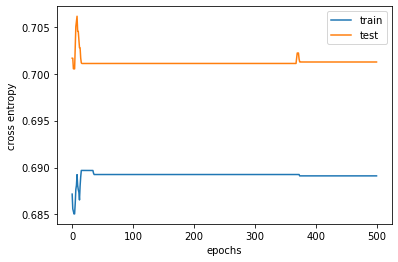

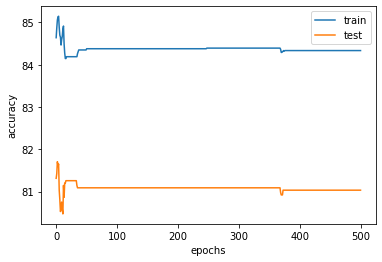

In [76]:
 
# Restore best model
adversary.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [195]:
dirname = os.path.dirname(os.path.abspath('output/adversary'))
os.makedirs(dirname, exist_ok=True)
torch.save(adversary, 'output/adversary')

Take it as it is for now, now save the parameters trained for BPR and adversary

Then train for an universal perturbation 

In [196]:
adversary(Rec.T[123,:])

tensor([ -6769.0171, -12874.8496,  13485.1533,    289.3758,  -8503.9385,
          6546.8594], grad_fn=<AddBackward0>)

In [197]:
 F.softmax(adversary(Rec.T[123,:]))

/tmp/ipykernel_25416/2343087404.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(adversary(Rec.T[123,:]))


tensor([0., 0., 1., 0., 0., 0.], grad_fn=<SoftmaxBackward0>)

In [198]:
F.kl_div(torch.Tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]).log(),  (adversary(Rec.T[123,:])), None, None, 'sum')

tensor(nan, grad_fn=<SumBackward0>)

In [199]:
# Load
adversary = torch.load('output/adversary')
# model(X_train)
uniform_dist = torch.Tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])  

In [200]:
#this is for indirectly optimize the pertubation

criteria = torch.nn.MSELoss()
transform_func = torch.nn.Linear(64, 64)#.cuda()

In [201]:
class fairness_reprogramming(nn.Module):
    def __init__(self, user_emb, item_emb, Rec, reg):
        super().__init__()
        ##init the embedding for U and I
        self.user_emb = user_emb
        self.item_emb = item_emb  
        self.reg = reg
        self.perturb = nn.Parameter(torch.empty(1, 64))  # dim embedding
        nn.init.xavier_normal_(self.perturb.data)

        
## forward cal
    def forward(self, u, i, j, epoch):
        """Return loss value.
        
        Args:
            u(torch.LongTensor): tensor stored user indexes. [batch_size,]
            i(torch.LongTensor): tensor stored item indexes which is prefered by user. [batch_size,]
            j(torch.LongTensor): tensor stored item indexes which is not prefered by user. [batch_size,]
            epoch

        Returns:
            torch.FloatTensor
        """
        ##u,i,j respectively, each is a vector of dim embedding (default = 64)
#         u = self.user_emb[u, :]
#         i = self.item_emb[i, :]
#         j = self.item_emb[j, :]

        ## Enables this Tensor to have their grad populated during backward(), convert any non-leaf tensor into a leaf tensor,
        ##https://stackoverflow.com/questions/73698041/how-retain-grad-in-pytorch-works-i-found-its-position-changes-the-grad-result
#         self.perturb.retain_grad()

#       transform perturbation
        perturb = transform_func(self.perturb)
    
        transformation_loss = criteria(self.perturb,perturb)
        ## mf, dot product of user with pos/neg item
        x_ui = torch.mul(self.user_emb[u, :] , self.item_emb[i, :] + perturb).sum(dim=1)
        x_uj = torch.mul(self.user_emb[u, :] , self.item_emb[j, :] + perturb).sum(dim=1)
        

        #extract prediction for item and genres 
        
        
        ## Fix here, adversary needs to predict the recommendation for embedding + perturbation
        
        #torch.matmul(list(model1.items())[0][1], list(model1.items())[1][1][i,:].T)
        #torch.matmul(self.user_emb,(self.item_emb[i, :] + perturb).T).T[i,:]
#         i_feature = torch.matmul(self.user_emb,(self.item_emb[i, :] + perturb).T).T[i,:]
#         j_feature = torch.matmul(self.user_emb,(self.item_emb[j, :] + perturb).T).T[j,:]
        i_feature = Rec.T[i,:]
        j_feature = Rec.T[j,:]
        
#         i_genre = item_genre[i,:]
#         j_genre = item_genre[j,:]
        
        
        i.prob = F.softmax(adversary(i_feature), dim =1 )#.mean(axis = 0)
        j.prob = F.softmax(adversary(j_feature), dim =1 )#.mean(axis = 0)
        
        
        
#         1000 in a batch, group A & B
#         A 300, B 700 (    [0.3, 0.7] vs [0.5 0.5]    )
        
#         Conditional prob P(g=Ga|i) for each item
        
        #similar to clip value, find diff between ui and uj
        x_uij =torch.clamp(x_ui - x_uj,min=-80.0,max=1e8)
        #logsigmoid this is equivalent to equation 1 in the paper (classic loss of bpr)
        log_prob = F.softplus(x_uij).sum()
        # regularization = lambda * l2 norm of u, i, j
        regularization = self.reg * (self.user_emb[u, :].norm(dim=1).pow(2).sum() + self.item_emb[i, :].norm(dim=1).pow(2).sum() + self.item_emb[j, :].norm(dim=1).pow(2).sum())

        ## original bpr loss,
        loss_bpr = -log_prob + regularization
#         loss_bpr.backward(retain_graph=True)
        
        
        loss_adv = F.kl_div(uniform_dist.log(), i.prob, None, None, 'sum') + F.kl_div(uniform_dist.log(), j.prob , None, None, 'sum')
        total_loss = transformation_loss + loss_bpr + loss_adv

        total_loss.backward()
        
        
        return total_loss, perturb
        

In [202]:
with open('preprocessed/ml-1m-6-test.pickle', 'rb') as f:
    dataset = pickle.load(f)
    user_size, item_size = dataset['user_size'], dataset['item_size']
    train_user_list, test_user_list = dataset['train_user_list'], dataset['test_user_list']
    train_pair = dataset['train_pair']

In [203]:
# Create dataset, model, optimizer
dataset = GetTriplePair(item_size, train_user_list, train_pair, True, 200)
#list(model1.items())[0][1], list(model1.items())[1][1]
# load batch of 512 item triplets
loader = DataLoader(dataset, batch_size=512)
model = fairness_reprogramming(list(model1.items())[0][1], list(model1.items())[1][1], Rec, 0)

In [204]:
optimizer = optim.Adam(model.parameters(), lr=0.000025)

# Training
start_time = time.time()
eval_best_loss = float('inf')

##zero_grad: zeroes the grad attribute of all the parameters passed to the optimizer upon construction
optimizer.zero_grad()
epoch = 0
HR_history = []
NDCG_history = []
perturb_list = []
# result_history = []
#loader has batch size of 512. In each batch there are 3 tensors of u i j accordingly
for u, i, j in loader:
    if epoch in range(200):
        loss,perturb = model(u, i, j, epoch)

        ##  updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
        optimizer.step()
        HR_list, NDCG_list = evaluate_k(list(model1.items())[0][1] + perturb,
                                        list(model1.items())[1][1] + perturb,
                                        train_user_list,
                                        test_user_list,
                                        klist=[50, 100])
        if epoch % 20 == (20- 1):
            if epoch in range(1000):
                print('BPR-MF Epoch [{}/{}]'.format(epoch + 1, 1000))
            print('loss: %.4f' % loss)
            print('HR@50: %.4f, HR@100: %.4f, NDCG@50: %.4f, NDCG@100: %.4f' % (
                HR_list[0], HR_list[1], NDCG_list[0], NDCG_list[1]))
        perturb_list.append(perturb)
        HR_history.append(HR_list[1])
        NDCG_history.append(NDCG_list[1])
        if epoch % 100 == 0:
            if loss < eval_best_loss:
                eval_best_loss = loss
                dirname = os.path.dirname(os.path.abspath('output/perturbation'))
                os.makedirs(dirname, exist_ok=True)
                torch.save(model.state_dict(), 'output/perturbation')
                time_dif = get_time_dif(start_time)
                print("time", time_dif)
        epoch += 1
    else:
        break


time 0:00:01
BPR-MF Epoch [20/1000]
loss: -3712.0742
HR@50: 0.2617, HR@100: 0.3875, NDCG@50: 0.0740, NDCG@100: 0.0740
BPR-MF Epoch [40/1000]
loss: -3373.8118
HR@50: 0.2619, HR@100: 0.3875, NDCG@50: 0.0740, NDCG@100: 0.0740
BPR-MF Epoch [60/1000]
loss: -3285.8896
HR@50: 0.2622, HR@100: 0.3876, NDCG@50: 0.0740, NDCG@100: 0.0740
BPR-MF Epoch [80/1000]
loss: -3185.8579
HR@50: 0.2621, HR@100: 0.3876, NDCG@50: 0.0742, NDCG@100: 0.0742
BPR-MF Epoch [100/1000]
loss: -3470.0930
HR@50: 0.2622, HR@100: 0.3877, NDCG@50: 0.0743, NDCG@100: 0.0743
time 0:00:21
BPR-MF Epoch [120/1000]
loss: -3425.1577
HR@50: 0.2622, HR@100: 0.3877, NDCG@50: 0.0742, NDCG@100: 0.0742
BPR-MF Epoch [140/1000]
loss: -3181.0874
HR@50: 0.2621, HR@100: 0.3877, NDCG@50: 0.0741, NDCG@100: 0.0741
BPR-MF Epoch [160/1000]
loss: -3311.9656
HR@50: 0.2621, HR@100: 0.3878, NDCG@50: 0.0740, NDCG@100: 0.0740
BPR-MF Epoch [180/1000]
loss: -3265.0930
HR@50: 0.2621, HR@100: 0.3877, NDCG@50: 0.0740, NDCG@100: 0.0740
BPR-MF Epoch [200/1000]


https://stackoverflow.com/questions/66572604/optimize-input-instead-of-network-in-pytorch

In [205]:
#load the results of BPR
pertubation = (torch.load('output/perturbation'))
list(pertubation.items())[0][1].size()


torch.Size([1, 64])

In [206]:
#load the results of BPR
model1 = (torch.load('output/bpr_manual'))
list(model1.items())[0][1].size(),list(model1.items())[1][1].size()



Rec = np.matmul(list(model1.items())[0][1]+list(pertubation.items())[0][1], (list(model1.items())[1][1]+list(pertubation.items())[0][1]).T)
Rec.size()
# Rec[1,:].size()


torch.Size([6036, 1481])

In [207]:
import utility
utility.ranking_analysis(Rec, vali_df, train_df, key_genre,
                                                      item_genre_list, user_genre_count)


####################################################################################################
# System-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00261		0.01256		0.02379		0.03527
# Horror		0.00000		0.00013		0.00053		0.00080
# Crime		0.00000		0.00051		0.00178		0.00394
# Adventure		0.00045		0.00204		0.00431		0.00711
# Children's		0.00430		0.02066		0.04244		0.06601
# Romance		0.00245		0.01200		0.02345		0.03565
# relative std		0.98087		0.95738		0.94931		0.93845
####################################################################################################
# User-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00527		0.02511		0.04786		0.06923
# Horror		0.00000		0.00038		0.00068		0.00115
# Crime		0.00000		0.00041		0.00156		0.00318
# Adventure		0.00049		0.00202		0.00441		0.00781
# Children's		0.00363		0.01713		0.03451		0.05329
# Romance		0.00244		0.01206		0.02358		0.03617
# relative std		1.01003		0.98753		0.95984		0.92365
###########

(array([0.83190748, 0.79776128, 0.79962675, 0.79576568]),
 array([0.98087123, 0.95738232, 0.94931415, 0.93845301]))

In [133]:
#before training
import utility
utility.ranking_analysis(Rec, vali_df, train_df, key_genre,
                                                      item_genre_list, user_genre_count)

/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:310: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/home/vuhoang181/Documents/code_base/APR-PyTorch/utility.py:310: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx


####################################################################################################
# System-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00383		0.02130		0.04567		0.07430
# Horror		0.00000		0.00013		0.00027		0.00053
# Crime		0.00038		0.00051		0.00102		0.00165
# Adventure		0.00053		0.00288		0.00552		0.00802
# Children's		0.00666		0.03342		0.06310		0.09056
# Romance		0.00007		0.00048		0.00095		0.00130
# relative std		1.30830		1.32240		1.30197		1.28849
####################################################################################################
# User-level Recall:
# 			Recall@1	Recall@5	Recall@10	Recall@15
# Sci-Fi		0.00216		0.01214		0.02675		0.04422
# Horror		0.00000		0.00005		0.00011		0.00035
# Crime		0.00009		0.00014		0.00029		0.00061
# Adventure		0.00114		0.00660		0.01232		0.01698
# Children's		0.00907		0.04610		0.08801		0.12748
# Romance		0.00002		0.00019		0.00043		0.00059
# relative std		1.54771		1.50576		1.46929		1.43754
###########

(array([0.78904869, 0.78396012, 0.85028607, 0.87491529]),
 array([1.3083043 , 1.32239504, 1.30196555, 1.2884858 ]))

In [17]:
torch.matmul(list(model1.items())[0][1], list(model1.items())[1][1][43,:].T)

tensor([1.9876, 3.1480, 2.5682,  ..., 1.8456, 2.9970, 1.9240])

In [143]:
for u in range(num_user):
        #for each user list all the items that he likes, mark that to -10000
        like_item = (train_df.loc[train_df['user_id'] == u, 'item_id']).tolist()
        Rec[u, like_item] = -100000.0

for u in range(num_user):  # iterate each user
    #extract item that user actually match during testing, extract the prediction
    u_test = (vali_df.loc[vali_df['user_id'] == u, 'item_id']).tolist()
    u_pred = Rec[u, :]
    
    top15_item_idx_no_train = np.argpartition(u_pred, -1 * 15)[-1 * 15:]
    top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
    top15 = sorted(top15, key=itemgetter(1), reverse=True)



/tmp/ipykernel_4087/1973552975.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T
/tmp/ipykernel_4087/1973552975.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top15 = (np.array([top15_item_idx_no_train, u_pred[top15_item_idx_no_train]])).T


In [217]:
utility.negative_sample(train_df, num_user, num_item, 5)

(1851145,
 array([[   0],
        [   0],
        [   0],
        ...,
        [6035],
        [6035],
        [6035]]),
 array([[  4],
        [  4],
        [  4],
        ...,
        [583],
        [583],
        [583]]),
 array([[1442],
        [ 440],
        [ 490],
        ...,
        [ 504],
        [ 560],
        [ 113]]))

In [218]:
set(range(num_item))

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [9]:
user = []
item_pos = []
item_neg = []
item_set = set(range(num_item))
for i in range(num_user):
    like_item = (train_df.loc[train_df['user_id'] == i, 'item_id']).tolist()
    unlike_item = list(item_set - set(like_item))
    if len(unlike_item) < 5:
        tmp_neg = len(unlike_item)
    else:
        tmp_neg = 5
    for l in like_item:
        neg_samples = (np.random.choice(unlike_item, size=tmp_neg, replace=False)).tolist()
        user += [i] * tmp_neg
        item_pos += [l] * tmp_neg
        item_neg += neg_samples
    num_sample = len(user)
#      num_sample, np.array(user).reshape((num_sample, 1)),\
#        np.array(item_pos).reshape((num_sample, 1)), np.array(item_neg).reshape((num_sample, 1))

In [10]:
np.array(user)

array([   0,    0,    0, ..., 6035, 6035, 6035])

In [11]:
like_item

[48,
 137,
 625,
 634,
 198,
 308,
 315,
 833,
 745,
 410,
 565,
 1164,
 337,
 511,
 840,
 790,
 690,
 186,
 47,
 964,
 122,
 136,
 346,
 28,
 44,
 63,
 651,
 39,
 133,
 98,
 1221,
 419,
 134,
 655,
 183,
 50,
 193,
 195,
 669,
 169,
 172,
 670,
 798,
 607,
 902,
 129,
 214,
 341,
 501,
 35,
 36,
 103,
 369,
 84,
 524,
 109,
 648,
 40,
 589,
 42,
 793,
 58,
 280,
 286,
 89,
 123,
 403,
 1116,
 597,
 22,
 495,
 767,
 303,
 306,
 115,
 349,
 153,
 61,
 70,
 67,
 298,
 317,
 71,
 342,
 353,
 240,
 358,
 507,
 578,
 583]